In [1]:
import pickle
import rpy2.robjects as robjects
import os
import xgboost
import scipy.stats as st
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
sns.set()
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
legend_fontsize = 14
ticks_fontsize = 18
figure_format = "pdf"
%matplotlib inline

## Load metadata for samples and subjects in GTEx

In [2]:
# load sample metadata: 18220 samples, 73 technnical parameters
sampleMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt', sep = '\t', header = 'infer', index_col=0)
# load sample metadata: 948 people, 174 phenotipic parameters
subjectMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep = '\t', header = 'infer', index_col=0)

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load data by tissue

In [18]:
def load_data(tissue, datatype):
    """ Load gene expression for each tissue.
    
     Parameters
    ----------
    tissue: one of GTEx tissues
    datatype: one of the strings "tissue", "subtissue", "deconvolved" depending on the datatype needed
    
     Outputs
    ----------
    data : pd.DataFrame
        genes x samples dataframe
    age : np.array, int
        age of each subject who provided the sample for the tissue
    SMRIN : np.array, float
        RIN number (RNA integrity number) for each sample
    SMTSISCH : np.array, int
        total ischemic time for each sample
    """
    
    if datatype == "tissue":
        #process pkl files (whole tissue)
        data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/Expr_by_tissue/Expr_by_tissue/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm_"+\
        str(tissue)+".pkl"
        if os.path.exists(data_p_file):
            data = pd.read_pickle(data_p_file)

            gene_ids = data['Name']
            gene_names = data['Description']
            data.index = gene_ids
            data = data.iloc[:,2:]
    
    elif datatype == "subtissue":
        #process r files (subtissues)
        data_r_file = "./GTEx_V8_RNASeq_subTissueTypes/GTEx_" + str(tissue) + ".RData"

        if os.path.exists(data_r_file):

            def load_file(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['GTEx_RNAseq']
                df = pd.DataFrame(
                    np.asarray(matrix.memoryview()),
                    index=matrix.rownames,
                    columns=matrix.colnames,
                    copy=True)
                robjects.globalenv.clear()
                return df

            data = load_file(data_r_file)
    
    elif datatype == "deconvolved":
        print("deconvolved not implemented yet")
        return
    else:
        print("please specify a valid datatype: tissue, subtissue, or deconvolved")
        return
    
    print(data.shape[1], " samples, ", data.shape[0], "genes")
    
    # filter out genes that are expressed in fewer than 10% of samples
    data = data[(data.T == 0).sum()<0.1*data.shape[1]]
    print(str(len((data.T == 0).sum()>0.1*data.shape[1])) + " genes filtered out")
    
    # filter out samples that express fewer than 10% of genes
    data = data.loc[:,data.columns[(pd.isna(data)).sum()<0.1*data.shape[0]]]
    print(str(len(data.columns[(pd.isna(data)).sum()>0.1*data.shape[0]])) + " samples filtered out")
    
    # load age, SNRIN, and SMTSUSCH values for each subject
    subject_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
     data.columns.tolist()]
    age = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subject_ids]
    SMRIN = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in data.columns.tolist()]
    SMTSISCH = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in data.columns.tolist()]
    return data, age, SMRIN, SMTSISCH

## Load and filter data

Choosing tissues that have > 800 samples (8 tissues in GTEx). It is arbitrary, so you can choose a lower threshold to study more tissues if your age prediciton model works even for fewer samples

In [19]:
tissues = ['Muscle',
 'Blood Vessel',
 'Brain',
 'Blood',
 'Skin',
 'Esophagus',
 'Heart',
 'Adipose Tissue']
# tissues = ['Adipose Tissue', 'Adipose_Subcutaneous'] 
# tissues = ['Muscle', 'Blood Vessel'] # tissues

In [20]:
data = {}
age = {}
SMRIN = {}
SMTSISCH = {}

for tissue in tissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue, "tissue")

804  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
1335  samples,  56200 genes
21218 genes filtered out
0 samples filtered out
2642  samples,  56200 genes
22135 genes filtered out
0 samples filtered out
1702  samples,  56200 genes
19334 genes filtered out
0 samples filtered out
1811  samples,  56200 genes
20767 genes filtered out
0 samples filtered out
1451  samples,  56200 genes
21402 genes filtered out
0 samples filtered out
866  samples,  56200 genes
20406 genes filtered out
0 samples filtered out
1204  samples,  56200 genes
22099 genes filtered out
0 samples filtered out


## Correct for covariates and remove outliers

### Find genes with weak correlation with age

In [68]:
def define_non_age_related_genes(data, age):
    rhos = np.zeros((len(data.index.tolist())))
    spear_pvals = np.zeros((len(data.index.tolist())))
    for i, gene in enumerate(data.index.tolist()):
        rhos[i], spear_pvals[i] = ss.spearmanr(data.loc[gene,:], age, nan_policy = 'omit')
    gene_idxs = range(data.shape[0])
    gene_idxs = [gene_idx for gene_idx in gene_idxs if spear_pvals[gene_idx]>0.01]
    print(str(len(gene_idxs)) + " genes with no correlation with age")
    non_aging_expr = data.iloc[gene_idxs,:]
    return(non_aging_expr)

### Perform SVD (singular value decomposition) of non-age related gene expression

In [69]:
def svd(non_aging_expr, n_comp = 50):
    u, s, vh  = np.linalg.svd(non_aging_expr.transpose())
    d2 = s**2
    print("first " + str(n_comp) + " components explain " + str(d2[:n_comp].sum()/d2.sum()) + " variability")
    print(u.shape)
    u_top_10 = u[:n_comp,:]
    x_0 = u_top_10*s
    return(x_0)

### Regress out non-age-related covariates

In [70]:
import sklearn.linear_model as linear_model
def linear_regression(x_train, y_train):
    ols = linear_model.LinearRegression()
    model = ols.fit(x_train, y_train)
    return ols.coef_, ols.intercept_, ols.predict(x_train)

def regress_covariates(data, x_0):
    coeffs, intercepts, prediction = linear_regression(x_0.transpose(), data.transpose()) 
    residual = (data.transpose()-np.asmatrix(x_0.transpose())*coeffs.transpose()).transpose()
    return residual

### Exclude non-age-related genes

In [71]:
def exclude_non_age_related_genes(residual, gene_idxs):
    aging_gene_idxs = [i for i in range(len(residual.index)) if i not in gene_idxs]
    residual_aging = residual.iloc[aging_gene_idxs,:]
    return(residual_aging)

### Remove outliers

In [72]:
def plot_PCA(X, ax, tissue):
    for i in range(len(X[:, 0])):
        ax.scatter(X[i, 0], X[i, 1], color = 'C0')
    ax.set_title(tissue, fontsize = title_fontsize)
    ax.set_xlabel('PC1', fontsize = xlabel_fontsize)
    ax.set_xlabel('PC2', fontsize = ylabel_fontsize)

In [73]:
from sklearn import decomposition
def detect_outliers(residual_aging, tissue):
    pca = decomposition.PCA(n_components=2)
    X = residual_aging.transpose().copy()
    pca.fit(X)
    X = pca.transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_PCA(X, ax, tissue)
    q1 = pd.DataFrame(X[:, 0]).quantile(0.999)
    q2 = pd.DataFrame(X[:, 1]).quantile(0.999)
    print(q1[0])
    print(q2[0])
    residual_no_outliers = residual_aging.iloc[:,np.asarray([j for j in \
                                                             range(len(residual_aging.columns)) \
                                                             if X[j, 0] < q1[0] and X[j, 1] < q2[0]])]
    print(str(residual_aging.shape[0] - residual_no_outliers.shape[0]) + " outliers removed")
    
    subj_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
                residual_no_outliers.columns.tolist()]
    ages = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subj_ids]
    SMRINs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    SMTSISCHs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    return residual_no_outliers, ages, SMRINs, SMTSISCHs

Muscle
9098 genes with no correlation with age
first 50 components explain 0.9998112297541029 variability
(803, 803)
66990.76865243509
76452.38636551371
0 outliers removed
Blood Vessel
8429 genes with no correlation with age
first 50 components explain 0.9984083167856997 variability
(1335, 1335)
103462.36856554553
24082.783353599923
0 outliers removed
Brain
6971 genes with no correlation with age
first 50 components explain 0.9997670501964327 variability
(2642, 2642)
116890.17814243535
111974.90145022576
0 outliers removed
Blood
7341 genes with no correlation with age
first 50 components explain 0.9936064012015714 variability
(929, 929)
467045.9413724144
166901.62726780793
0 outliers removed
Skin
12502 genes with no correlation with age
first 50 components explain 0.9987557180550182 variability
(1809, 1809)
62994.590302017714
57825.441734421955
0 outliers removed
Esophagus
10696 genes with no correlation with age
first 50 components explain 0.999272003939996 variability
(1445, 1445)
10

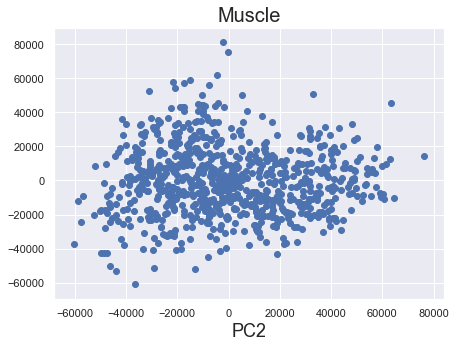

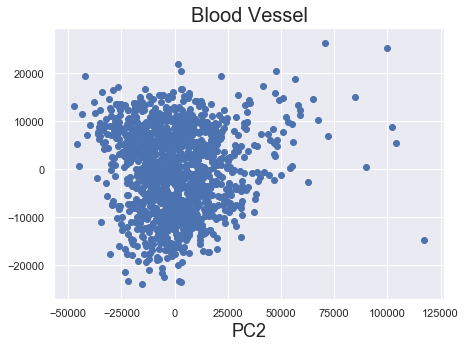

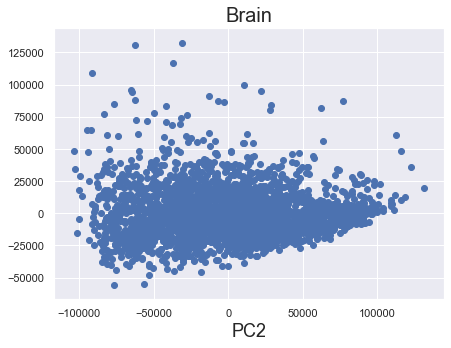

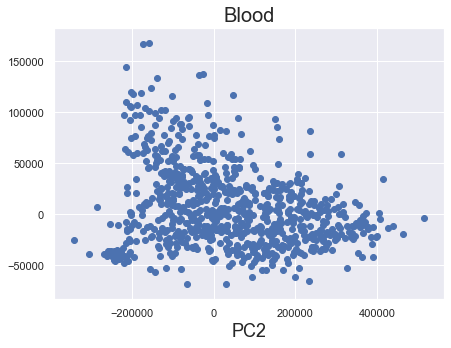

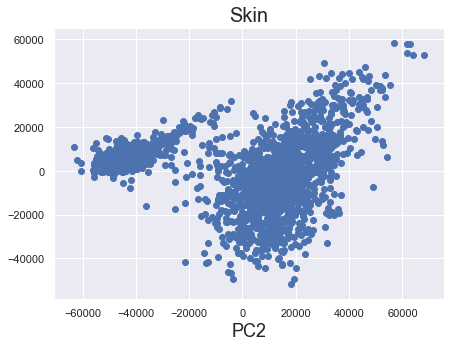

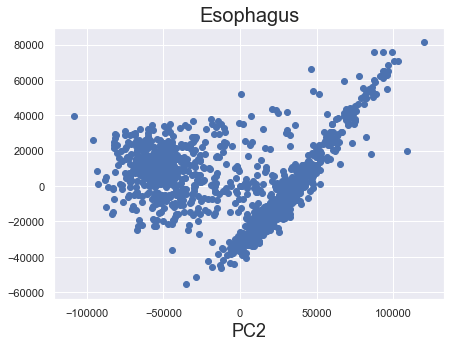

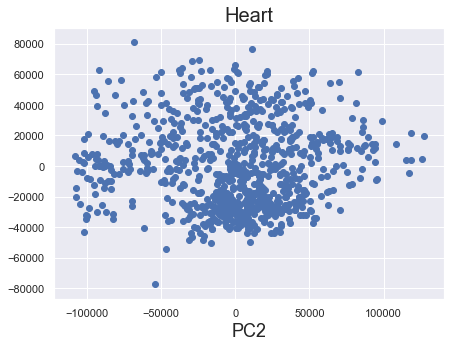

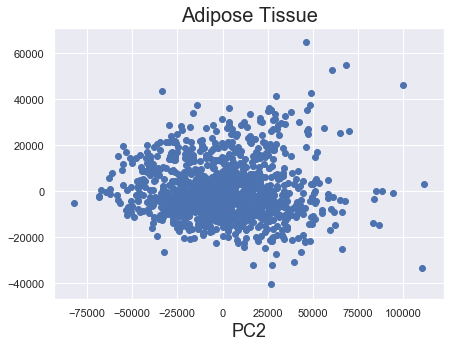

In [74]:
non_aging_expr = {}
x_0 = {}
residual = {}
residual_aging = {}
residual_no_outliers = {}
ages = {}
SMRINs = {}
SMTSISCHs = {}

for i, tissue in enumerate(tissues):
        print(tissue)
        
        non_aging_expr[tissue] = define_non_age_related_genes(data[tissue], age[tissue])
        x_0[tissue] = svd(non_aging_expr[tissue], n_comp=50)
        residual[tissue] = regress_covariates(data[tissue], x_0[tissue])
        residual_aging[tissue] = exclude_non_age_related_genes(residual[tissue], \
                                                               non_aging_expr[tissue].index.tolist())
        residual_no_outliers[tissue], ages[tissue], SMRINs[tissue], SMTSISCHs[tissue] = \
        detect_outliers(residual_aging[tissue], tissue)

## Build the model predicting age with xgboost

In [8]:
def split_train_valid_test(num_examples,training_proportion,validation_proportion,test_proportion):
    assert training_proportion<=1.0
    assert validation_proportion<=1.0
    assert test_proportion<=1.0
    assert (training_proportion+validation_proportion+test_proportion)<=1.0

    idx_shuff=np.random.RandomState(seed=77).permutation(range(num_examples))

    training_threshold=int(num_examples*training_proportion)
    validation_threshold=int(num_examples*(training_proportion+validation_proportion))

    training=range(training_threshold)
    validation=range(training_threshold,min(validation_threshold,num_examples))
    test=range(validation_threshold,num_examples)

    return(idx_shuff[list(training)],idx_shuff[list(validation)],idx_shuff[list(test)])

In [167]:
import scipy.stats as st
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

def xgboost_model(x_train, y_train, x_test, y_test, n_iter=2, cv=5): # adapted from UROP work, changed n_iter from 10 to 2

    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test, y_test)
    
#     params = {
#         # Parameters that we are going to tune.
#         'max_depth':6,
#         'min_child_weight': 1,
#         'eta':.3,
#         'subsample': 1,
#         'colsample_bytree': 1,
#         # Other parameters
#         'objective':'reg:squarederror',
#     }
#     params['eval_metric'] = "mae"
#     num_boost_round = 999
    
#     # "Learn" the mean from the training data
#     mean_train = np.mean(y_train)
#     # Get predictions on the test set
#     baseline_predictions = np.ones(y_test.shape) * mean_train
#     # Compute MAE
#     mae_baseline = mean_absolute_error(y_test, baseline_predictions)
#     print("Baseline MAE is {:.2f}".format(mae_baseline)) # baseline is 9.81

#     model = xgb.train(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         evals=[(dtest, "Test")],
#         early_stopping_rounds=10
#     )
#     print("Best MAE: {:.2f} with {} rounds".format(
#                  model.best_score,
#                  model.best_iteration+1))
# #     Best MAE: 8.10 with 17 rounds

#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         seed=42,
#         nfold=5,
#         metrics={'mae'},
#         early_stopping_rounds=10
#     )
#     print(cv_results)
#         train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
#     32        0.021495       0.002374       8.656529      0.594512

    n_estimators = [100, 150, 200, 250, 300] 
    max_depth = [6, 8, 10, 12]
    min_child_weight = [1, 2, 4, 8] 
    learning_rate = [.3, .1, .03, .01, .003, .001]
    subsample = [.8, .9, 1.0]
    colsample = [.8, .9, 1.0]

#     from_zero_positive = [0, 0.5, 1] #st.expon(0, 10) #same, for reg_alpha
#     reg_lambda = st.expon(0, 10) #same
#     scale_pos_weight = [1,2,3,4,5,6,7,8,9,10] #scale_pos_weight (1:1 ratio) as we match class imbalance #[1,2,3,4,5,6,7,8,9,10]
    
    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate':learning_rate,
                    "min_child_weight": min_child_weight,
                    "colsample_bytree": colsample,
                    "subsample": subsample}
    xgb_tune = xgb.XGBRegressor()
#     xgb_tune = xgb.XGBRegressor(tree_method='gpu_hist') # gpu enabled

#     param = {'n_estimators': 20}
# #     num_round = 2
#     clf = xgb.XGBRegressor(missing=np.nan)
#     clf.set_params(**param)
#     clf.fit(x_train, y_train)
#     print("model trained")
    
#     preds = clf.predict(x_test)
#     return preds

#     bst = xgb.train(param, x_train, num_round)
#     # make prediction
# #     preds = bst.predict(dtest)
#     return bst

    print("done prior to search")
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = -1,scoring='neg_root_mean_squared_error', return_train_score = True)
    xgb_hyper.fit(x_train, y_train)
    print("done after search")
    preds = xgb_hyper.predict(x_test)
    
    parameter_tuning = xgb_hyper.cv_results_
    parameter_tuning = pd.DataFrame(parameter_tuning)
    print(parameter_tuning)
    print(parameter_tuning[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']])
    print(xgb_hyper.best_params_)
    print(xgb_hyper.best_score_)
#     return xgb_hyper.best_estimator_,parameter_tuning 
    return preds

In [166]:
def fit_xgboost_model(residual_no_outliers, ages, tissue, search = False, n_iter=5):
    """ Build an age predictor with the xgboost model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    
    x_train = residual_no_outliers.iloc[:,train].transpose()
    x_test = residual_no_outliers.iloc[:,test].transpose()
    print("data done")
    print(x_train.shape, x_test.shape, ages_train.shape, ages_test.shape)
    
    if search:
        ages_pred_test = xgboost_model(x_train, ages_train, x_test, ages_test, n_iter=n_iter)
    else:
        ages_pred_test = final_xgboost_model(x_train, ages_train, x_test, ages_test) # replaced with hardcoded values

    print("predictions made")
    print(ages_pred_test[:10], ages_test[:10])
    
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print("prior pearson", pearsonr)
    
    return(pearsonr, ages_test, ages_pred_test)

In [162]:
def graph_correlation(ages_test, ages_pred_test, tissue):
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print("real pearson", pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
#     pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
    #     plt.savefig(pp, format = figure_format)
    #     return(genes, score, pearsonr, ages_test, ages_pred_test)
    return pearsonr

In [172]:
def final_xgboost_model(x_train, y_train, x_test, y_test): # using set hyperparameters
    
    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test, y_test)
        
#     # refactor later, no need for RandomizedSearchCV
#     n_estimators = [150] 
#     max_depth = [6]
#     min_child_weight = [1] 
#     learning_rate = [.1]
#     subsample = [1.0]
#     colsample = [.9]

#     random_grid = {'n_estimators': n_estimators,
#                     'max_depth': max_depth,
#                     'learning_rate':learning_rate,
#                     "min_child_weight": min_child_weight,
#                     "colsample_bytree": colsample,
#                     "subsample": subsample}
#     xgb_tune = xgb.XGBRegressor()
    
    # old params
#     param = {'n_estimators': 150,
#             'max_depth': 6,
#             'learning_rate': 0.1,
#             'min_child_weight': 1,
#             'colsample_bytree': .9,
#             'subsample': 1.0}
    # new params
    param = {'subsample': 0.8, 'n_estimators': 200, 
             'min_child_weight': 8, 'max_depth': 6, 
             'learning_rate': 0.1, 'colsample_bytree': 1.0}
    
    clf = xgb.XGBRegressor()
    clf.set_params(**param)
    clf.fit(x_train, y_train)
    
    xgboost.plot_importance(clf, max_num_features = 10)
    plt.show()
    
    preds = clf.predict(x_test)
    return preds

#     xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = -1,scoring='neg_root_mean_squared_error', return_train_score = True)
#     xgb_hyper.fit(x_train, y_train)
#     preds = xgb_hyper.predict(x_test)
#     return preds

In [205]:
# store all data

%store pearson_corr
%store prediction
%store true
# %store data
%store age
# %store SMRIN
# %store SMTSISCH
# %store non_aging_expr
# %store x_0 
# %store residual
# %store residual_aging
# %store residual_no_outliers
# %store ages 
# %store SMRINs
# %store SMTSISCHs 
%store pearson_corr_new
%store prediction_new
%store true_new
# %store data_new
%store age_new

Stored 'pearson_corr' (dict)
Stored 'prediction' (dict)
Stored 'true' (dict)
Stored 'age' (dict)
Stored 'pearson_corr_new' (dict)
Stored 'prediction_new' (dict)
Stored 'true_new' (dict)
Stored 'age_new' (dict)


In [155]:
pearson_corr = {}
prediction = {}
true = {}

In [77]:
for i, tissue in enumerate(tissues): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)

Muscle
(19544, 803)
Blood Vessel
(21218, 1335)
Brain
(22135, 2642)
Blood
(19334, 929)
Skin
(20767, 1809)
Esophagus
(21402, 1445)
Heart
(20406, 861)
Adipose Tissue
(22099, 1204)


In [79]:
tissueData = [data[tissue] for tissue in tissues]
combined = pd.concat(tissueData, axis=0, join='inner')
print(combined.shape)

(166905, 0)


In [115]:
tissueData = {tissue: data[tissue] for tissue in tissues}
ageData = {tissue: pd.DataFrame([age[tissue]]) for tissue in tissues}

def renaming_tissue(tissue):
    f = lambda x : x + "_" + tissue
    return f
    
rename_tiss = lambda tissue : renaming_tissue(tissue)

for t in tissueData:
    tissueData[t].columns = [c[:10] for c in tissueData[t].columns]
    ageData[t].columns = [c[:10] for c in tissueData[t].columns]
    
    duplicated = tissueData[t].columns.duplicated()
    tissueData[t] = tissueData[t].loc[:,~duplicated] # remove duplicate columns
    
    tissueData[t] = tissueData[t].T.rename(columns=rename_tiss(t)).T
    ageData[t] = ageData[t].loc[:,~duplicated]

# combined = pd.concat(tissueData, axis=0, join='inner')
# print(combined.shape)

# # newData = {tissue: data[tissue] for tissue in tissues}
# musCols = sorted([c[:10] for c in data["Muscle"].columns])
# bloCols = sorted([c[:10] for c in data["Blood"].columns])
# print(musCols[:50])
# print(bloCols[:50])
# print("total muscle:", len(musCols))
# print("total blood:", len(bloCols))
# print("unique muscle:", len(set(musCols)))
# print("unique blood:", len(set(bloCols)))
# # print(len(set(musCols).intersection(set(bloCols))))
# # print(set(musCols).intersection(set(bloCols)))
# # # print(data["Muscle"]['GTEX-15G19-0526-SM-6PAMT'])

In [168]:
combineTissue = pd.concat([tissueData[t] for t in tissues], axis=0, join='inner')
combineAge = pd.concat([ageData[t] for t in tissues], axis=0, join='inner')
combineAge = combineAge.iloc[0].values.tolist()
print(combineAge)
combineName = "All Tissues"

data[combineName] = combineTissue
age[combineName] = combineAge
print(combineName)
pearson_corr[combineName], true[combineName], prediction[combineName] = fit_xgboost_model(combineTissue, combineAge, combineName, search=True, n_iter=10)

[62, 66, 61, 66, 53, 48, 69, 66, 59, 55, 37, 66, 62, 64, 49, 67, 68, 64, 50, 59, 66, 64, 53, 65, 63, 48, 48, 59, 69, 63, 59, 57, 56, 62, 55, 65, 68, 64, 59, 69, 70, 58, 60, 61, 64, 57, 51, 69, 65, 47, 68, 70, 58, 51, 66, 51, 53, 66, 68, 41, 70, 69, 67, 62, 57, 47, 68, 36, 57, 60, 62, 70, 62, 63, 60, 69, 58, 68, 64, 52, 53, 54, 56, 65, 68, 61, 43, 52, 59, 51, 47, 47, 46]
All Tissues
data done
(65, 166905) (28, 166905) (65,) (28,)
done prior to search
done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     223.506600      4.573990         9.215056        0.559872   
1     272.677088      3.263312         8.388869        1.101939   
2     284.124374     11.596863         8.728798        0.651225   
3     157.424834      6.827454         8.611788        1.066374   
4     593.449067     12.639684         8.731000        0.849163   
5     312.567909     15.458748         7.437106        0.328946   
6     431.519025      7.333215         7.122363        0.26

real pearson (0.5613392585865197, 0.0018840830742425016)


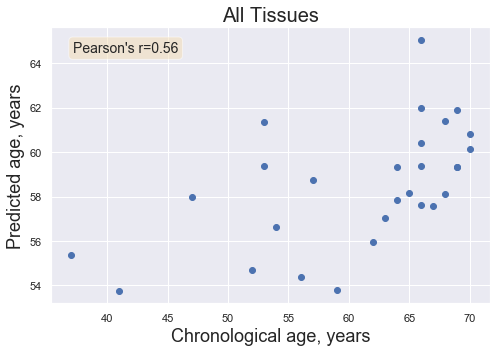

In [169]:
pearson_corr[combineName] = graph_correlation(true[combineName], prediction[combineName], combineName)

Muscle + Blood Vessel
data done
(486, 40762) (209, 40762) (486,) (209,)


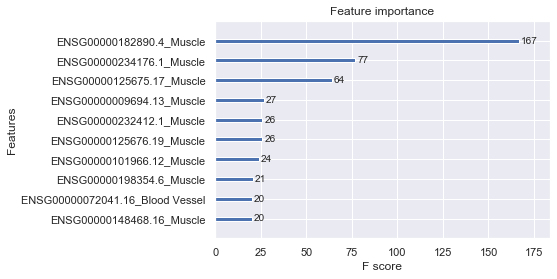

predictions made
[57.466167 59.332443 54.966057 54.228992 43.911602 51.982433 56.96952
 60.422775 52.911148 56.436207] [52 65 68 50 29 61 60 56 40 62]
prior pearson (nan, nan)
real pearson (0.7470990897988511, 1.4244693162031988e-38)
Muscle + Brain
data done
(229, 41679) (99, 41679) (229,) (99,)


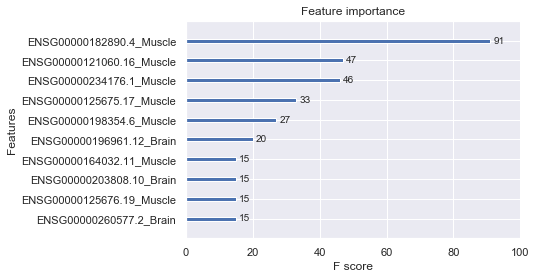

predictions made
[58.315704 60.433334 57.25731  62.06888  62.490078 63.46349  56.924614
 63.28269  60.136284 62.112324] [55 53 59 70 60 59 50 66 70 65]
prior pearson (nan, nan)
real pearson (0.3946794205457213, 5.287892388438424e-05)
Muscle + Blood
data done
(459, 38878) (197, 38878) (459,) (197,)


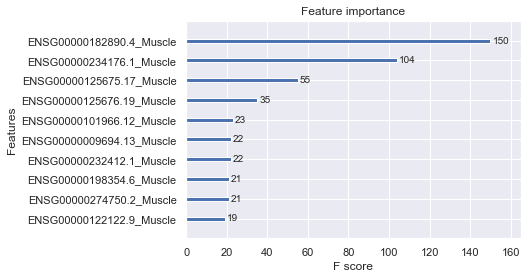

predictions made
[48.19504  48.40576  53.1471   41.61827  51.543373 42.12657  59.45708
 61.71778  37.718727 49.607635] [51 35 54 27 60 49 69 68 51 54]
prior pearson (nan, nan)
real pearson (0.6447499911743144, 1.551468088484324e-24)
Muscle + Skin
data done
(546, 40311) (234, 40311) (546,) (234,)


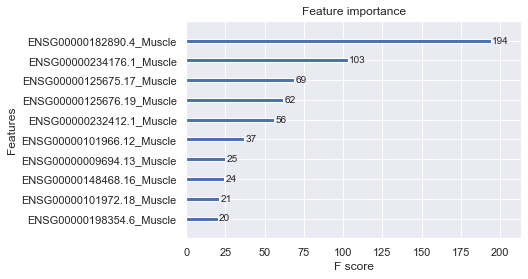

predictions made
[60.064972 61.114777 53.043526 53.061523 42.2249   55.000748 49.096336
 58.0569   51.543365 57.202652] [65 33 54 58 29 68 61 55 53 63]
prior pearson (nan, nan)
real pearson (0.7482926054863144, 3.093007444718448e-43)
Muscle + Esophagus
data done
(429, 40946) (184, 40946) (429,) (184,)


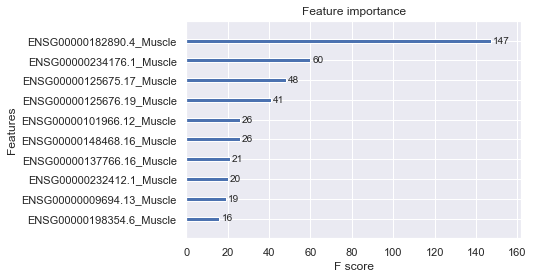

predictions made
[35.893066 30.431843 45.979584 53.497353 46.233757 47.097095 46.287754
 56.5406   53.442707 51.21451 ] [28 22 49 60 41 54 45 62 56 53]
prior pearson (nan, nan)
real pearson (0.7525861466329969, 7.402374862858263e-35)
Muscle + Heart
data done
(345, 39950) (148, 39950) (345,) (148,)


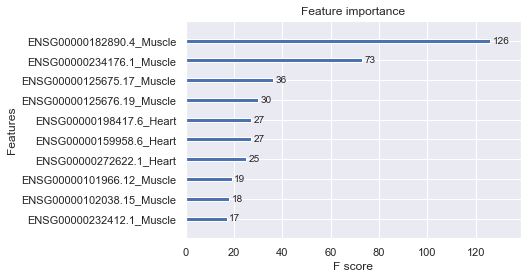

predictions made
[54.52624  62.744053 54.44111  49.39019  59.546604 62.031345 55.211502
 61.48345  52.605186 58.183018] [61 70 55 54 62 69 62 59 68 51]
prior pearson (nan, nan)
real pearson (0.4317383985463215, 4.284350821660126e-08)
Muscle + Adipose Tissue
data done
(493, 41643) (212, 41643) (493,) (212,)


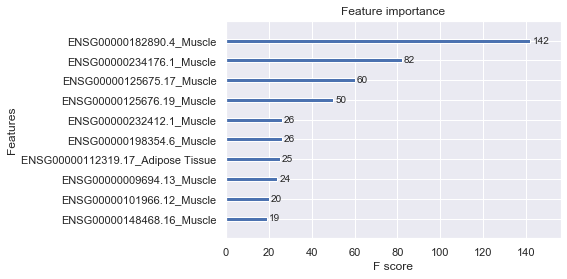

predictions made
[59.327206 50.472622 53.34278  55.995132 55.26716  57.63359  52.504536
 56.361168 53.474518 36.42291 ] [70 57 50 58 63 57 64 57 45 30]
prior pearson (nan, nan)
real pearson (0.6572960781571614, 1.328657334538451e-27)
Blood Vessel + Brain
data done
(203, 43353) (88, 43353) (203,) (88,)


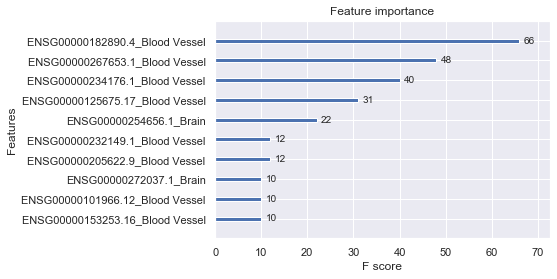

predictions made
[60.68101  55.77156  57.23217  49.550632 58.267456 55.76012  52.716217
 57.322063 44.65426  61.255146] [65 51 48 59 69 57 34 47 27 60]
prior pearson (nan, nan)
real pearson (0.6176084840144259, 1.460342532627695e-10)
Blood Vessel + Blood
data done
(455, 40552) (196, 40552) (455,) (196,)


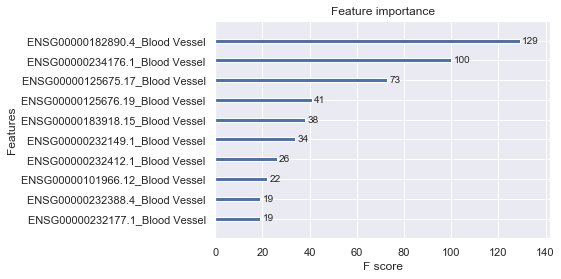

predictions made
[57.90535  36.961063 56.18674  60.85167  53.318256 57.62577  54.56458
 59.21349  44.18123  47.62878 ] [51 22 46 68 64 68 63 39 32 48]
prior pearson (nan, nan)
real pearson (0.7401293083205241, 2.845950657030231e-35)
Blood Vessel + Skin
data done
(533, 41985) (229, 41985) (533,) (229,)


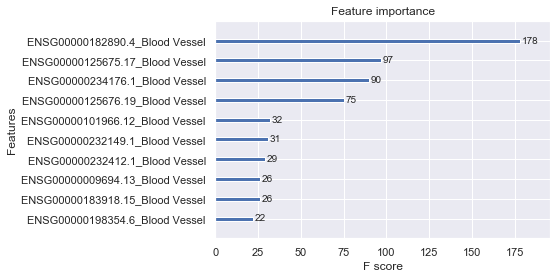

predictions made
[56.602676 54.401783 52.320454 57.2631   45.749416 58.192608 56.096924
 65.565285 51.818962 54.97595 ] [58 27 33 66 30 61 57 66 63 55]
prior pearson (nan, nan)
real pearson (0.7513220768070237, 7.465189551424026e-43)
Blood Vessel + Esophagus
data done
(436, 42620) (188, 42620) (436,) (188,)


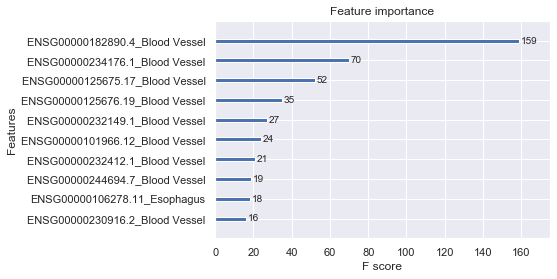

predictions made
[47.410805 56.137115 59.008907 45.126785 59.381622 53.04065  51.25991
 44.464954 38.708004 35.110317] [48 61 69 53 66 69 55 40 45 69]
prior pearson (nan, nan)
real pearson (0.7403950717001013, 6.406264602162009e-34)
Blood Vessel + Heart
data done
(349, 41624) (150, 41624) (349,) (150,)


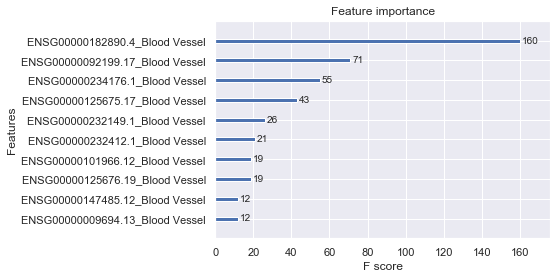

predictions made
[59.72958  52.824657 50.021267 50.95255  55.57654  52.871716 54.624355
 56.1725   60.350346 61.65425 ] [64 50 58 67 57 62 42 64 68 68]
prior pearson (nan, nan)
real pearson (0.5558722573630753, 1.53639905180091e-13)
Blood Vessel + Adipose Tissue
data done
(479, 43317) (206, 43317) (479,) (206,)


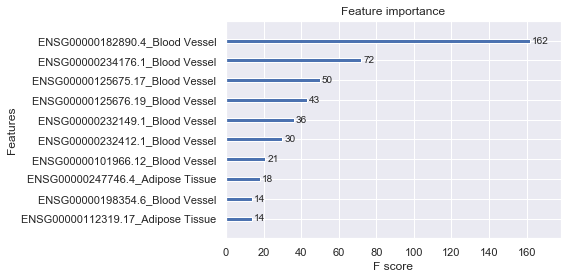

predictions made
[62.61974  55.743065 53.89328  52.299286 27.160864 53.926678 56.59088
 59.897366 51.978275 51.28024 ] [57 63 49 53 24 56 59 65 56 54]
prior pearson (nan, nan)
real pearson (0.7475166146943522, 4.227102364597947e-38)
Brain + Blood
data done
(205, 41469) (89, 41469) (205,) (89,)


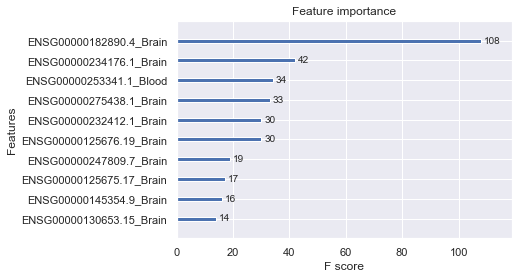

predictions made
[49.275288 53.81176  59.18023  60.607502 62.30815  56.759724 61.88541
 58.583744 57.83341  58.48907 ] [53 62 51 70 63 42 58 51 70 65]
prior pearson (nan, nan)
real pearson (0.4324924274667501, 2.309977394202307e-05)
Brain + Skin
data done
(257, 42902) (111, 42902) (257,) (111,)


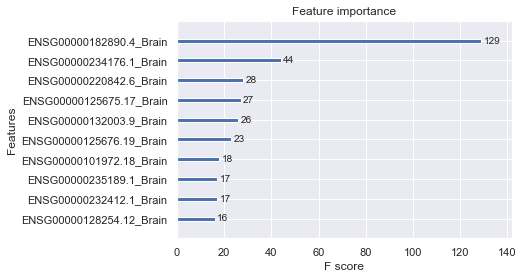

predictions made
[49.061775 40.278316 60.006363 58.778713 58.151764 61.890965 62.926483
 54.62188  56.76776  60.991234] [60 63 70 70 53 46 57 64 66 68]
prior pearson (nan, nan)
real pearson (0.3711615291279818, 6.0618054772189423e-05)
Brain + Esophagus
data done
(158, 43537) (69, 43537) (158,) (69,)


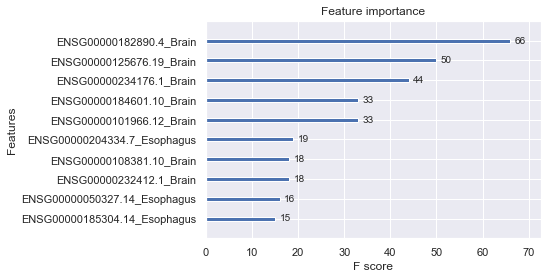

predictions made
[59.6714   61.36601  51.609627 61.26742  58.99661  53.273243 61.468727
 52.829056 54.3244   62.582626] [68 46 56 65 57 64 59 68 62 67]
prior pearson (nan, nan)
real pearson (0.16411516388850514, 0.17782098327291704)
Brain + Heart
data done
(175, 42541) (76, 42541) (175,) (76,)


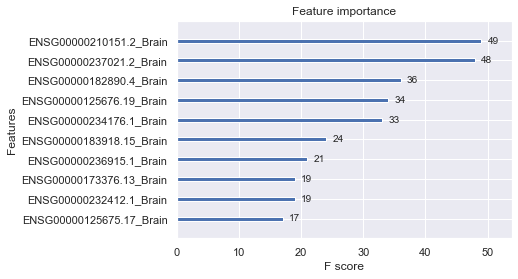

predictions made
[53.67041  56.519432 61.698853 59.201374 49.745102 56.46606  59.615456
 60.980118 54.98892  58.044434] [49 50 64 53 54 69 49 41 25 61]
prior pearson (nan, nan)
real pearson (0.2446726573735422, 0.03315944343590128)
Brain + Adipose Tissue
data done
(222, 44234) (96, 44234) (222,) (96,)


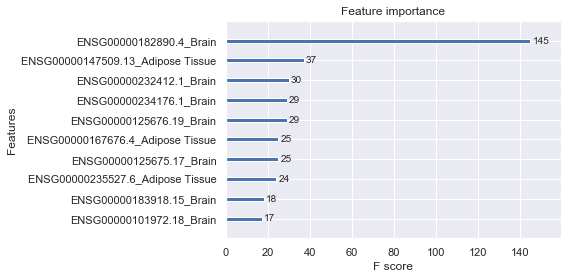

predictions made
[60.947205 59.894478 56.698547 55.811428 59.303177 63.37959  63.46488
 57.234016 59.9689   58.534466] [70 63 63 57 64 68 67 64 62 68]
prior pearson (nan, nan)
real pearson (0.2878545940939797, 0.004456543656847042)
Blood + Skin
data done
(518, 40101) (223, 40101) (518,) (223,)


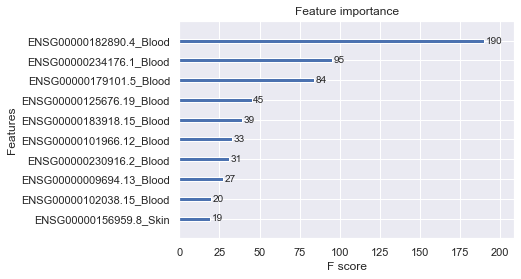

predictions made
[48.061092 56.41865  63.166615 35.864513 59.552208 39.809982 60.066994
 59.165794 56.633476 33.56719 ] [51 66 59 27 67 52 58 48 50 54]
prior pearson (nan, nan)
real pearson (0.49336631880618254, 4.4086023230708535e-15)
Blood + Esophagus
data done
(410, 40736) (176, 40736) (410,) (176,)


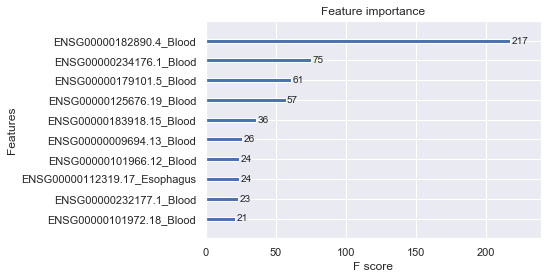

predictions made
[46.74962  54.06406  56.847546 49.11064  56.271538 57.870655 46.097103
 47.13938  60.112644 46.00434 ] [49 46 66 47 49 62 50 57 55 53]
prior pearson (nan, nan)
real pearson (0.599193489436677, 1.5627415745885251e-18)
Blood + Heart
data done
(324, 39740) (140, 39740) (324,) (140,)


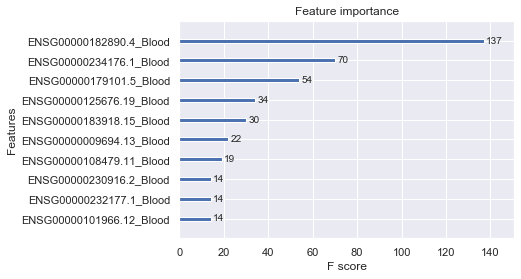

predictions made
[61.5111   52.66894  38.987175 51.463436 44.795193 58.1234   61.850037
 46.22055  56.417664 48.800438] [62 64 51 45 70 53 70 61 70 47]
prior pearson (nan, nan)
real pearson (0.18986559086602048, 0.024649137561262625)
Blood + Adipose Tissue
data done
(459, 41433) (197, 41433) (459,) (197,)


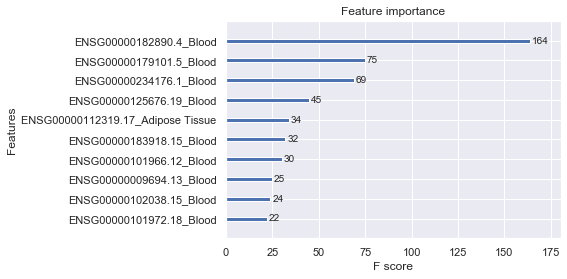

predictions made
[43.05482  57.89415  44.647533 60.781994 50.473335 42.83284  64.49611
 58.92177  56.37897  49.416843] [33 57 51 59 37 62 68 54 62 62]
prior pearson (nan, nan)
real pearson (0.6150972829913146, 6.838547177680912e-22)
Skin + Esophagus
data done
(484, 42169) (208, 42169) (484,) (208,)


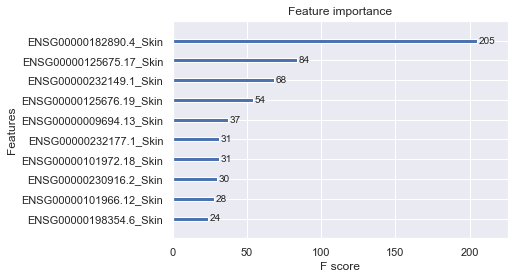

predictions made
[48.760803 53.7389   59.155838 55.876396 43.351875 43.57525  56.33304
 49.0144   51.1841   36.465305] [49 61 69 50 24 55 56 49 48 38]
prior pearson (nan, nan)
real pearson (0.5556311956344091, 3.0137500689432043e-18)
Skin + Heart
data done
(379, 41173) (163, 41173) (379,) (163,)


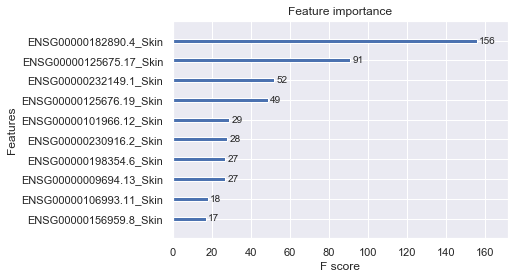

predictions made
[48.723747 47.755024 52.46073  62.236244 50.127033 57.89372  55.78234
 44.014584 54.337704 53.922188] [64 54 47 68 41 54 55 55 63 61]
prior pearson (nan, nan)
real pearson (0.5005354197390963, 1.0191330124380234e-11)
Skin + Adipose Tissue
data done
(546, 42866) (235, 42866) (546,) (235,)


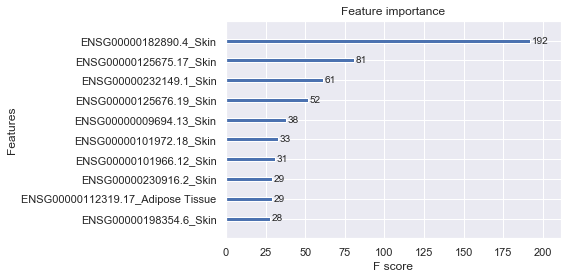

predictions made
[59.24972  61.801815 51.101215 58.887745 58.28104  34.179382 46.0617
 59.66544  49.19345  60.12013 ] [70 68 50 57 70 24 70 57 66 53]
prior pearson (nan, nan)
real pearson (0.6612072716363094, 6.483457906645157e-31)
Esophagus + Heart
data done
(312, 41808) (134, 41808) (312,) (134,)


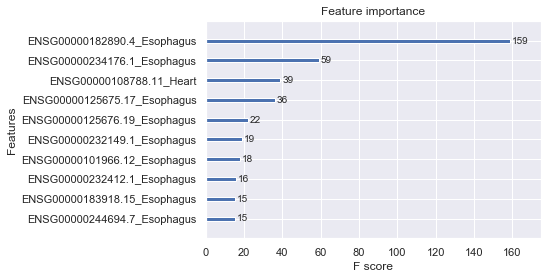

predictions made
[47.503567 62.302135 60.95751  56.895947 50.134468 57.616158 56.64627
 59.416317 59.044834 55.937878] [64 68 62 69 32 68 47 57 53 64]
prior pearson (nan, nan)
real pearson (0.46810329423133745, 1.1753034947318851e-08)
Esophagus + Adipose Tissue
data done
(440, 43501) (189, 43501) (440,) (189,)


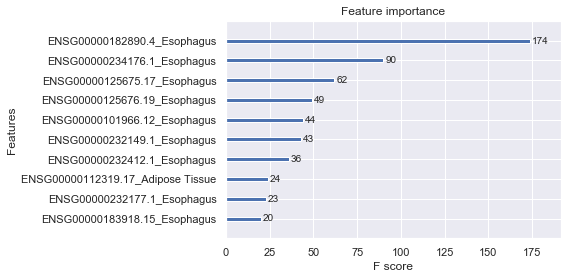

predictions made
[60.376396 60.607586 47.206154 53.609814 49.640945 51.99756  56.43265
 54.11204  27.600998 51.988033] [65 57 36 69 49 55 54 62 21 55]
prior pearson (nan, nan)
real pearson (0.6134742604960672, 6.321888044110336e-21)
Heart + Adipose Tissue
data done
(348, 42505) (150, 42505) (348,) (150,)


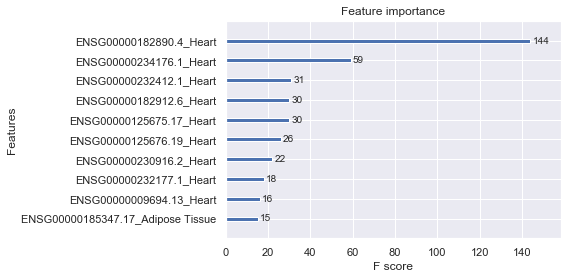

predictions made
[62.088886 47.974197 49.119835 56.60262  56.56146  48.15466  50.47377
 61.476837 53.415657 54.506397] [70 60 50 63 53 54 43 67 62 35]
prior pearson (nan, nan)
real pearson (0.3866818566602021, 1.0200039159295112e-06)


In [171]:
# analysis of all pairwise sets of tissues
for m in range(len(tissueData)):
    for n in range(m+1, len(tissueData)):
        i = tissues[m] # tissue names
        j = tissues[n]
        combineTissue = pd.concat([tissueData[i], tissueData[j]], axis=0, join='inner')
        combineAge = pd.concat([ageData[i], ageData[j]], axis=0, join='inner')
        combineAge = combineAge.iloc[0].values.tolist()
        combineName = i + " + " + j

        data[combineName] = combineTissue
        age[combineName] = combineAge
        print(combineName)
        pearson_corr[combineName], true[combineName], prediction[combineName] = fit_xgboost_model(combineTissue, combineAge, combineName)
        pearson_corr[combineName] = ss.pearsonr(prediction[combineName], true[combineName])
        print("real pearson", pearson_corr[combineName])

Muscle + Blood Vessel
data done
(486, 40762) (209, 40762) (486,) (209,)


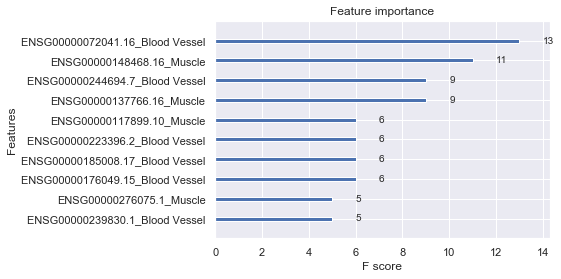

predictions made
[56.13354  57.02372  59.701527 47.893314 46.60718  46.16854  57.623814
 58.56974  51.12554  58.77705 ] [52 65 68 50 29 61 60 56 40 62]
prior pearson (nan, nan)
real pearson (0.7344623023409494, 1.0624977475380725e-36)
Muscle + Brain
data done
(229, 41679) (99, 41679) (229,) (99,)


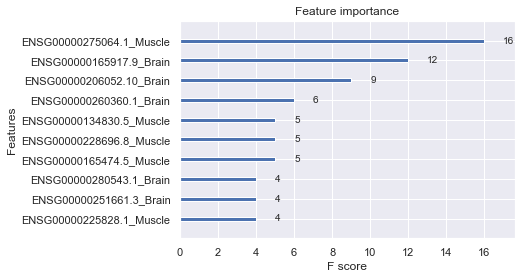

predictions made
[57.367733 57.04572  54.516346 59.310577 60.25082  62.168068 54.99337
 62.03474  59.039284 60.80061 ] [55 53 59 70 60 59 50 66 70 65]
prior pearson (nan, nan)
real pearson (0.4673323630789001, 1.079110392031254e-06)
Muscle + Blood
data done
(459, 38878) (197, 38878) (459,) (197,)


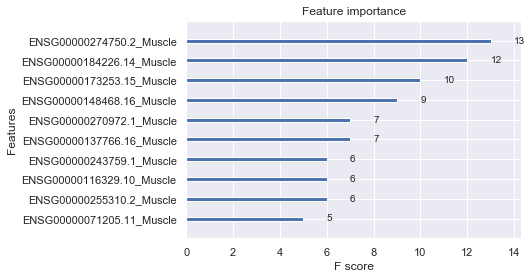

predictions made
[50.58502  52.869064 52.421074 42.55713  49.16647  40.622692 62.78272
 64.173706 40.60597  45.29638 ] [51 35 54 27 60 49 69 68 51 54]
prior pearson (nan, nan)
real pearson (0.6767060087433548, 9.856278603363317e-28)
Muscle + Skin
data done
(546, 40311) (234, 40311) (546,) (234,)


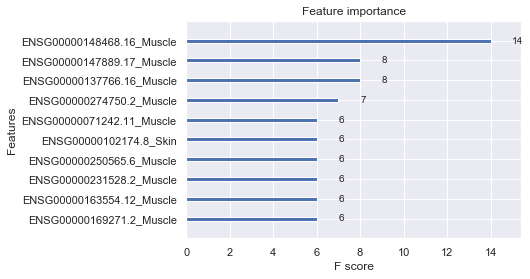

predictions made
[64.60538  58.97923  56.59534  53.615574 41.330368 56.853683 49.81518
 59.10602  51.355015 56.849716] [65 33 54 58 29 68 61 55 53 63]
prior pearson (nan, nan)
real pearson (0.7576454388341525, 7.018783783765089e-45)
Muscle + Esophagus
data done
(429, 40946) (184, 40946) (429,) (184,)


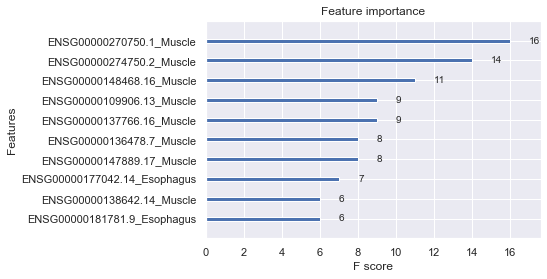

predictions made
[34.57098  38.981346 46.565945 52.330124 54.76209  52.90691  42.17088
 56.109158 51.48972  48.91313 ] [28 22 49 60 41 54 45 62 56 53]
prior pearson (nan, nan)
real pearson (0.7571566383574504, 1.7093200631364898e-35)
Muscle + Heart
data done
(345, 39950) (148, 39950) (345,) (148,)


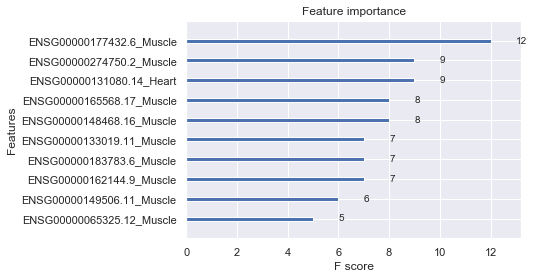

predictions made
[57.44093  60.892662 46.126984 50.639927 53.480503 58.091522 51.986435
 59.87722  55.40425  58.510235] [61 70 55 54 62 69 62 59 68 51]
prior pearson (nan, nan)
real pearson (0.5582024890824612, 1.6935976218941671e-13)
Muscle + Adipose Tissue
data done
(493, 41643) (212, 41643) (493,) (212,)


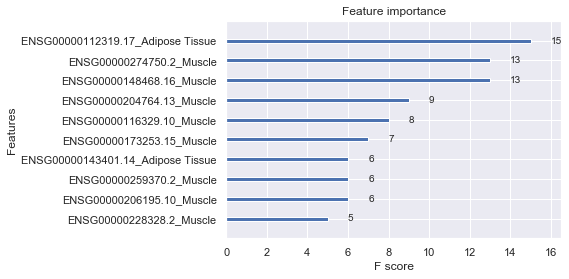

predictions made
[59.244545 56.981236 57.03741  57.49939  64.883995 62.509865 52.85879
 52.44036  52.0007   38.724754] [70 57 50 58 63 57 64 57 45 30]
prior pearson (nan, nan)
real pearson (0.7335777931122386, 4.4368087803843746e-37)
Blood Vessel + Brain
data done
(203, 43353) (88, 43353) (203,) (88,)


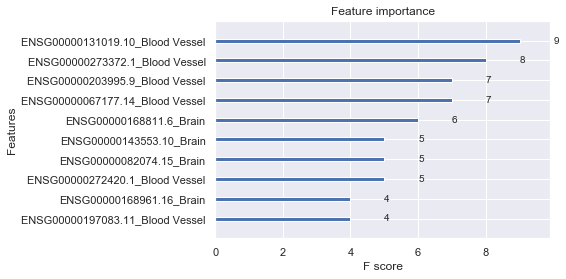

predictions made
[64.75221  63.348354 56.286064 52.123814 58.615665 60.94107  54.56375
 62.770485 40.292328 60.689365] [65 51 48 59 69 57 34 47 27 60]
prior pearson (nan, nan)
real pearson (0.5963298823552994, 8.766501183955139e-10)
Blood Vessel + Blood
data done
(455, 40552) (196, 40552) (455,) (196,)


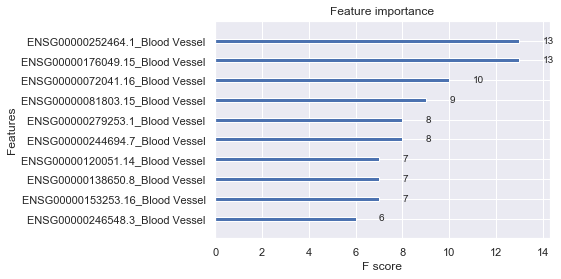

predictions made
[58.6747   39.61384  56.19054  61.368935 59.17389  57.212864 51.410995
 59.62172  47.210938 44.51832 ] [51 22 46 68 64 68 63 39 32 48]
prior pearson (nan, nan)
real pearson (0.7835534662434576, 5.831698212651566e-42)
Blood Vessel + Skin
data done
(533, 41985) (229, 41985) (533,) (229,)


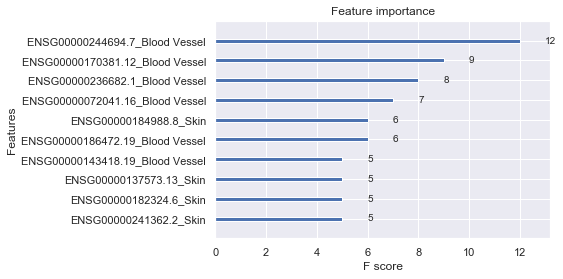

predictions made
[58.323467 54.081413 53.746662 57.93686  47.917377 61.377857 57.6918
 62.469963 52.288025 53.866646] [58 27 33 66 30 61 57 66 63 55]
prior pearson (nan, nan)
real pearson (0.7927461413621573, 1.0486531150753547e-50)
Blood Vessel + Esophagus
data done
(436, 42620) (188, 42620) (436,) (188,)


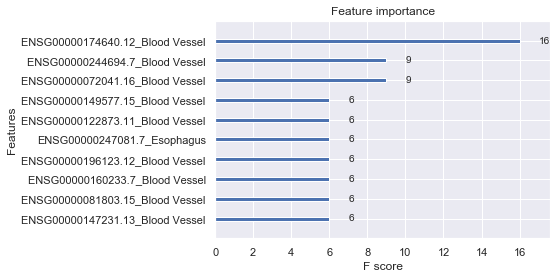

predictions made
[53.355816 50.757107 58.833904 43.16661  59.051743 51.36483  55.269672
 45.257637 40.15527  42.014267] [48 61 69 53 66 69 55 40 45 69]
prior pearson (nan, nan)
real pearson (0.7541059298911168, 8.398323954759667e-36)
Blood Vessel + Heart
data done
(349, 41624) (150, 41624) (349,) (150,)


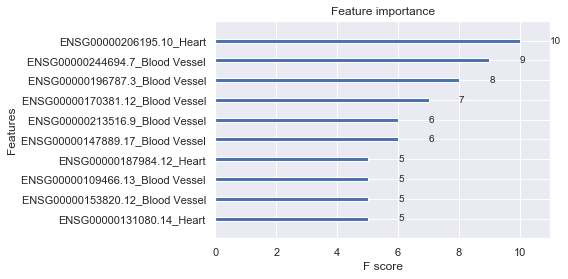

predictions made
[57.972214 48.6051   51.65184  56.372116 55.562126 54.70732  45.11172
 60.029152 59.494324 57.894577] [64 50 58 67 57 62 42 64 68 68]
prior pearson (nan, nan)
real pearson (0.6446593920712576, 5.496721431803232e-19)
Blood Vessel + Adipose Tissue
data done
(479, 43317) (206, 43317) (479,) (206,)


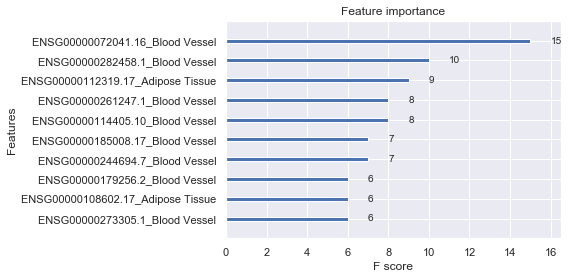

predictions made
[60.34446  55.78891  52.59643  51.10972  25.77082  50.21482  53.088776
 53.808678 53.494553 50.16324 ] [57 63 49 53 24 56 59 65 56 54]
prior pearson (nan, nan)
real pearson (0.7246035168699341, 7.992204270920312e-35)
Brain + Blood
data done
(205, 41469) (89, 41469) (205,) (89,)


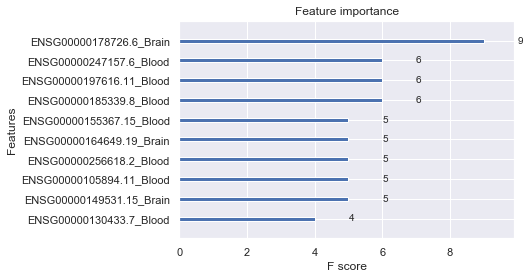

predictions made
[48.43971  58.107765 53.62066  54.1662   57.150303 58.285557 58.770275
 57.62883  53.337997 61.184963] [53 62 51 70 63 42 58 51 70 65]
prior pearson (nan, nan)
real pearson (0.3812310800055174, 0.00022788798085075313)
Brain + Skin
data done
(257, 42902) (111, 42902) (257,) (111,)


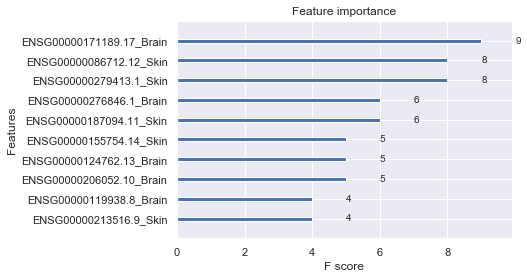

predictions made
[61.900887 48.89858  63.036957 60.844273 48.60058  60.325066 63.677563
 56.963245 60.450897 60.152344] [60 63 70 70 53 46 57 64 66 68]
prior pearson (nan, nan)
real pearson (0.364138568281145, 8.537885008458424e-05)
Brain + Esophagus
data done
(158, 43537) (69, 43537) (158,) (69,)


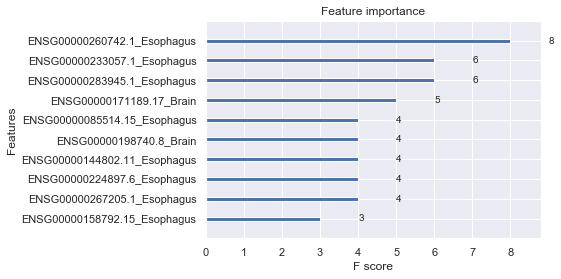

predictions made
[53.762558 62.10452  43.46655  61.493603 51.64506  47.341675 58.930187
 49.55108  56.673264 65.25239 ] [68 46 56 65 57 64 59 68 62 67]
prior pearson (nan, nan)
real pearson (0.2167744599678239, 0.07359750963240894)
Brain + Heart
data done
(175, 42541) (76, 42541) (175,) (76,)


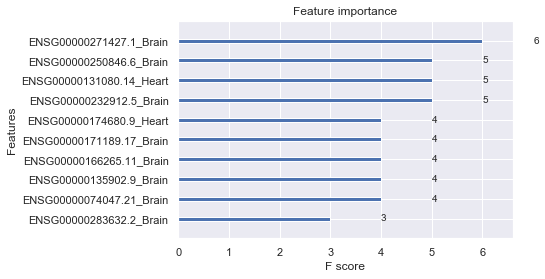

predictions made
[54.446983 58.338306 63.205856 64.44777  46.58725  54.772976 58.069065
 56.93768  49.941544 59.651123] [49 50 64 53 54 69 49 41 25 61]
prior pearson (nan, nan)
real pearson (0.2832373703255189, 0.013164769355838312)
Brain + Adipose Tissue
data done
(222, 44234) (96, 44234) (222,) (96,)


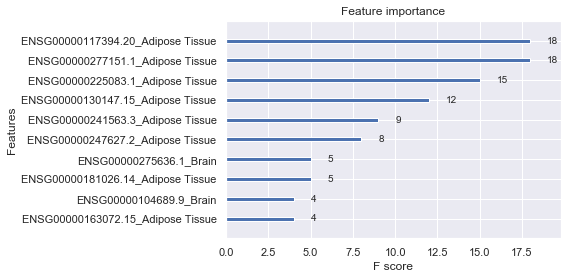

predictions made
[66.06576  62.28684  59.85814  57.160923 61.320583 64.14285  64.105484
 60.946217 61.037926 58.34298 ] [70 63 63 57 64 68 67 64 62 68]
prior pearson (nan, nan)
real pearson (0.3739872127031824, 0.00017440063554199664)
Blood + Skin
data done
(518, 40101) (223, 40101) (518,) (223,)


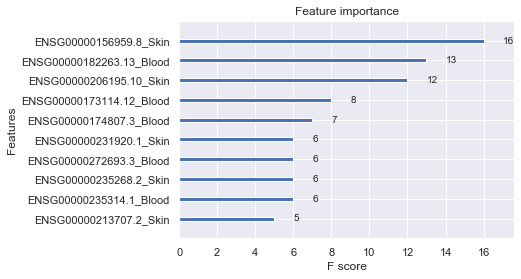

predictions made
[48.349518 52.631138 54.97807  35.980164 57.168083 37.743694 61.505547
 54.77783  55.245407 35.157368] [51 66 59 27 67 52 58 48 50 54]
prior pearson (nan, nan)
real pearson (0.5261093589265254, 2.8305859311989696e-17)
Blood + Esophagus
data done
(410, 40736) (176, 40736) (410,) (176,)


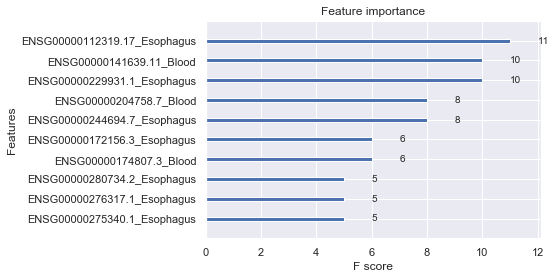

predictions made
[45.411297 55.630863 52.857525 42.30286  49.415417 54.663532 50.513565
 55.33076  59.737373 40.521935] [49 46 66 47 49 62 50 57 55 53]
prior pearson (nan, nan)
real pearson (0.6483612363430058, 2.290131060449756e-22)
Blood + Heart
data done
(324, 39740) (140, 39740) (324,) (140,)


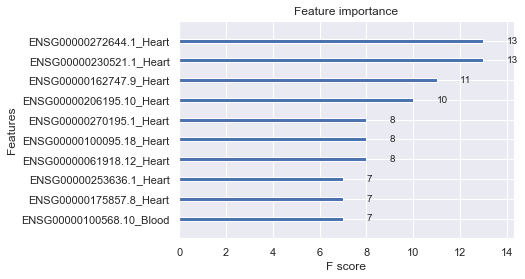

predictions made
[55.094173 48.64355  41.38446  48.470448 51.86783  58.11493  64.317566
 46.66538  56.966427 54.69695 ] [62 64 51 45 70 53 70 61 70 47]
prior pearson (nan, nan)
real pearson (0.3062127009756693, 0.00023372358723044106)
Blood + Adipose Tissue
data done
(459, 41433) (197, 41433) (459,) (197,)


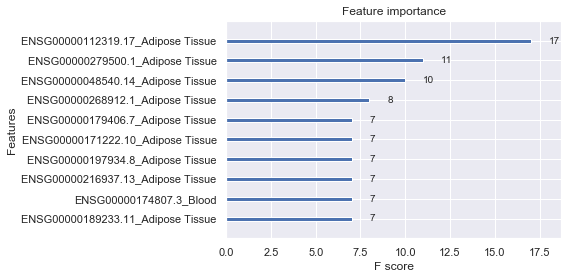

predictions made
[48.882935 56.213593 52.128296 61.353115 47.184822 51.92626  63.294468
 57.867    56.49468  48.72941 ] [33 57 51 59 37 62 68 54 62 62]
prior pearson (nan, nan)
real pearson (0.5989062354159413, 1.4600531801682825e-20)
Skin + Esophagus
data done
(484, 42169) (208, 42169) (484,) (208,)


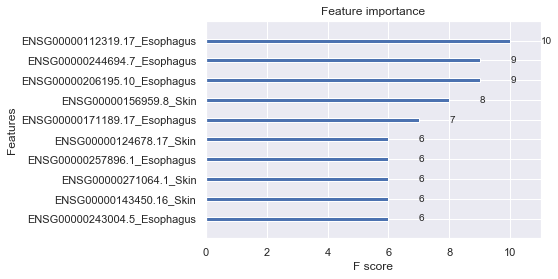

predictions made
[53.36637  60.156967 57.918053 59.228703 39.770172 56.175655 54.331573
 47.736618 51.358997 41.480522] [49 61 69 50 24 55 56 49 48 38]
prior pearson (nan, nan)
real pearson (0.6441988155021164, 8.917047788776973e-26)
Skin + Heart
data done
(379, 41173) (163, 41173) (379,) (163,)


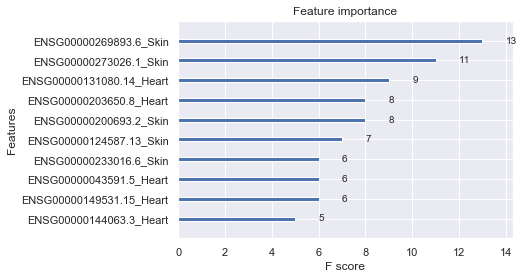

predictions made
[50.195934 52.207687 45.575504 59.705013 50.498337 60.023636 54.951538
 48.22034  57.25756  58.43033 ] [64 54 47 68 41 54 55 55 63 61]
prior pearson (nan, nan)
real pearson (0.43547864895065025, 6.261298745659371e-09)
Skin + Adipose Tissue
data done
(546, 42866) (235, 42866) (546,) (235,)


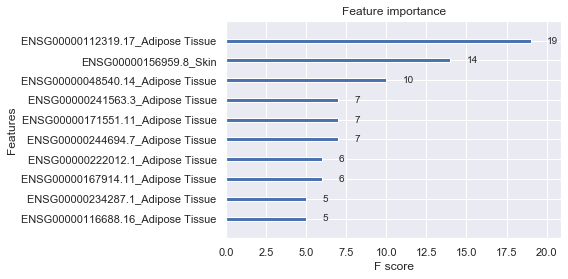

predictions made
[62.590508 61.81631  53.3593   59.8469   56.590107 33.033295 54.31441
 64.24753  57.83141  57.519955] [70 68 50 57 70 24 70 57 66 53]
prior pearson (nan, nan)
real pearson (0.7116002038309829, 1.394953144569469e-37)
Esophagus + Heart
data done
(312, 41808) (134, 41808) (312,) (134,)


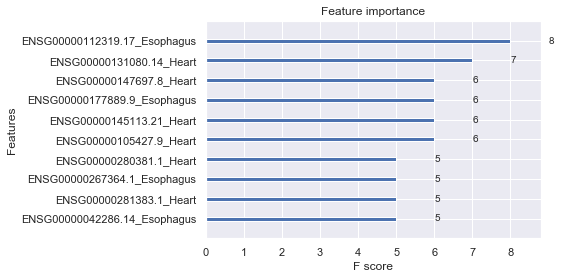

predictions made
[45.44648  61.931763 61.73311  49.078693 50.800713 58.9907   55.995922
 62.92325  58.336536 56.781086] [64 68 62 69 32 68 47 57 53 64]
prior pearson (nan, nan)
real pearson (0.4705816935812423, 9.604438052762142e-09)
Esophagus + Adipose Tissue
data done
(440, 43501) (189, 43501) (440,) (189,)


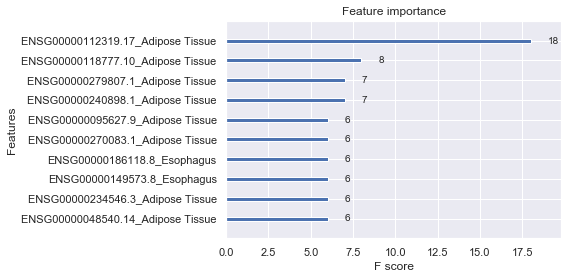

predictions made
[61.617207 58.69601  48.445225 53.89732  56.664974 50.569813 58.932972
 55.29907  35.129795 47.85847 ] [65 57 36 69 49 55 54 62 21 55]
prior pearson (nan, nan)
real pearson (0.6396423746607409, 3.889465168793787e-23)
Heart + Adipose Tissue
data done
(348, 42505) (150, 42505) (348,) (150,)


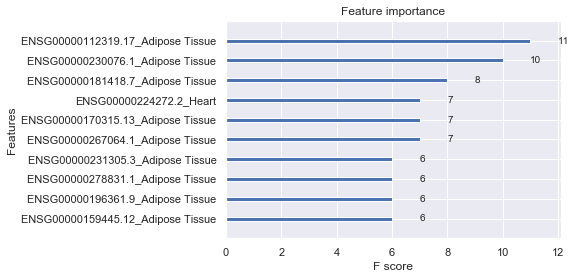

predictions made
[60.526012 50.396706 44.72047  57.46036  59.125465 48.260654 48.53623
 63.155174 53.25679  57.767757] [70 60 50 63 53 54 43 67 62 35]
prior pearson (nan, nan)
real pearson (0.45746515199712534, 3.974626982854516e-09)


In [174]:
pearson_corr_new = {}
true_new = {}
prediction_new = {}
data_new = {}
age_new = {}

# analysis of all pairwise sets of tissues, repeating with new hyperparams
for m in range(len(tissueData)):
    for n in range(m+1, len(tissueData)):
        i = tissues[m] # tissue names
        j = tissues[n]
        combineTissue = pd.concat([tissueData[i], tissueData[j]], axis=0, join='inner')
        combineAge = pd.concat([ageData[i], ageData[j]], axis=0, join='inner')
        combineAge = combineAge.iloc[0].values.tolist()
        combineName = i + " + " + j

        data_new[combineName] = combineTissue
        age_new[combineName] = combineAge
        print(combineName)
        pearson_corr_new[combineName], true_new[combineName], prediction_new[combineName] = fit_xgboost_model(combineTissue, combineAge, combineName)
        pearson_corr_new[combineName] = ss.pearsonr(prediction_new[combineName], true_new[combineName])
        print("real pearson", pearson_corr_new[combineName])

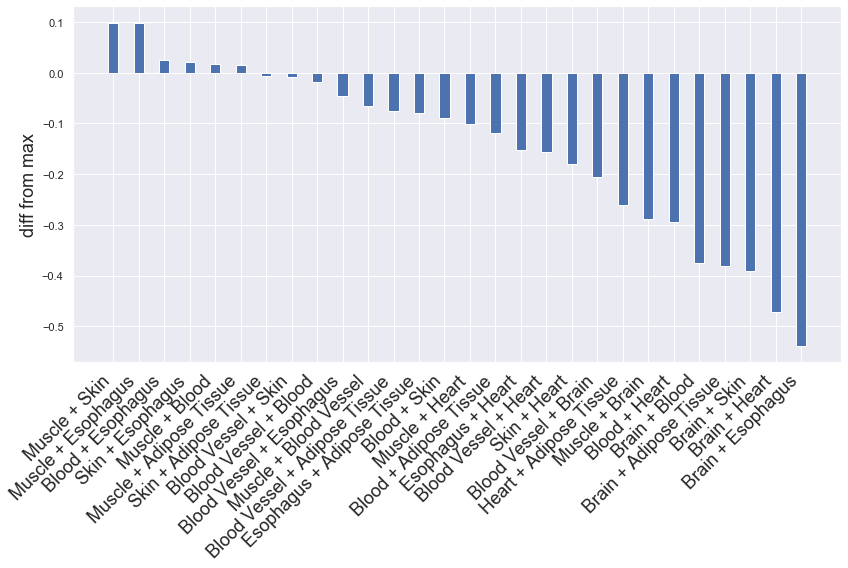

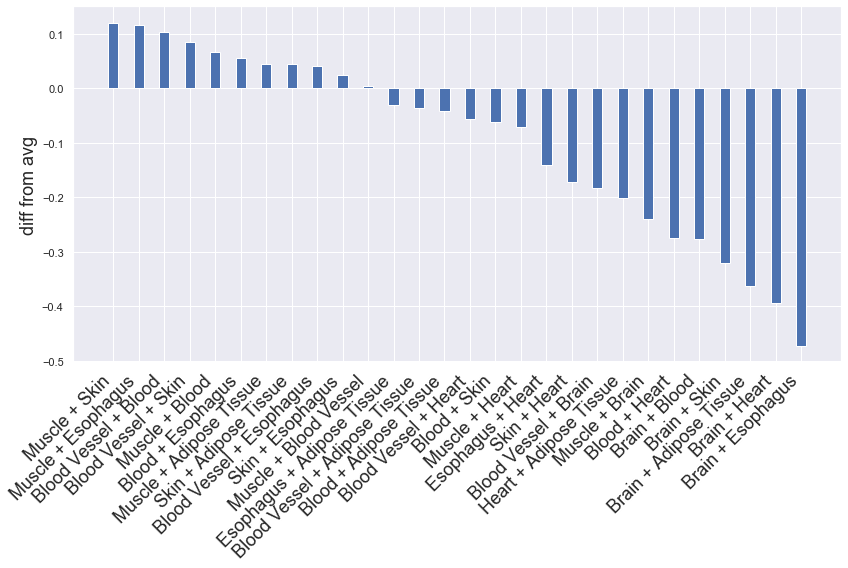

In [202]:
all_names = []
diff_max = []
diff_avg = []

for m in range(len(tissueData)):
    for n in range(m+1, len(tissueData)):
        i = tissues[m] # tissue names
        j = tissues[n]
        combined = [i, j, i + " + " + j]
        all_names.append(i + " + " + j)
        diff_max.append(pearson_corr_new[i + " + " + j][0] - max(pearson_corr[i][0], pearson_corr[j][0]))
        diff_avg.append(pearson_corr_new[i + " + " + j][0] - (pearson_corr[i][0] + pearson_corr[j][0])/2.0)

                    
fig, ax = plt.subplots(figsize=(12,8))
n=2
x_coords = np.arange(0,n*len(all_names), n)
ax.set_xticks(np.arange(0,n*len(all_names), n))
coeff = np.asarray(diff_max)
ax.set_xticklabels([all_names[i] for i in np.argsort(coeff)[::-1]], rotation=45, horizontalalignment='right', fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('diff from max', fontsize=ylabel_fontsize) 
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12,8))
n=2
x_coords = np.arange(0,n*len(all_names), n)
ax.set_xticks(np.arange(0,n*len(all_names), n))
coeff = np.asarray(diff_avg)
ax.set_xticklabels([all_names[i] for i in np.argsort(coeff)[::-1]], rotation=45, horizontalalignment='right', fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('diff from avg', fontsize=ylabel_fontsize) 
plt.tight_layout()

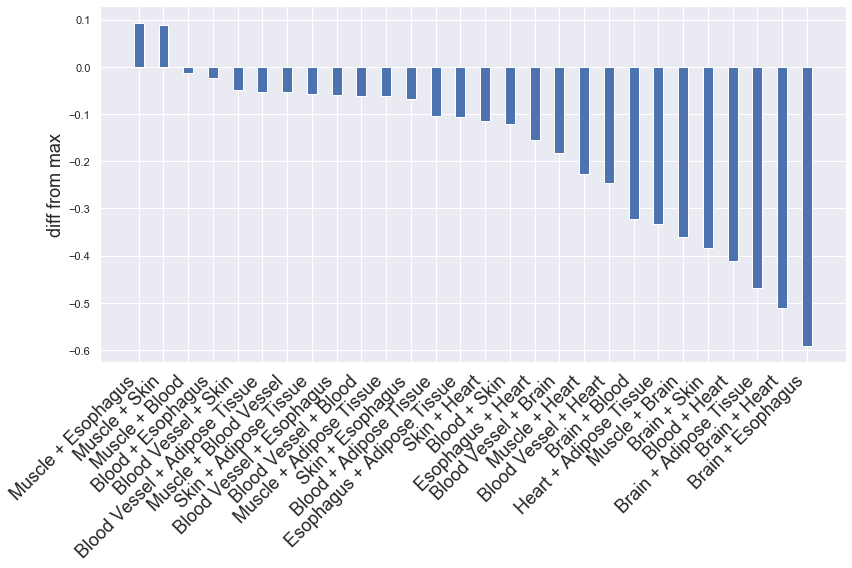

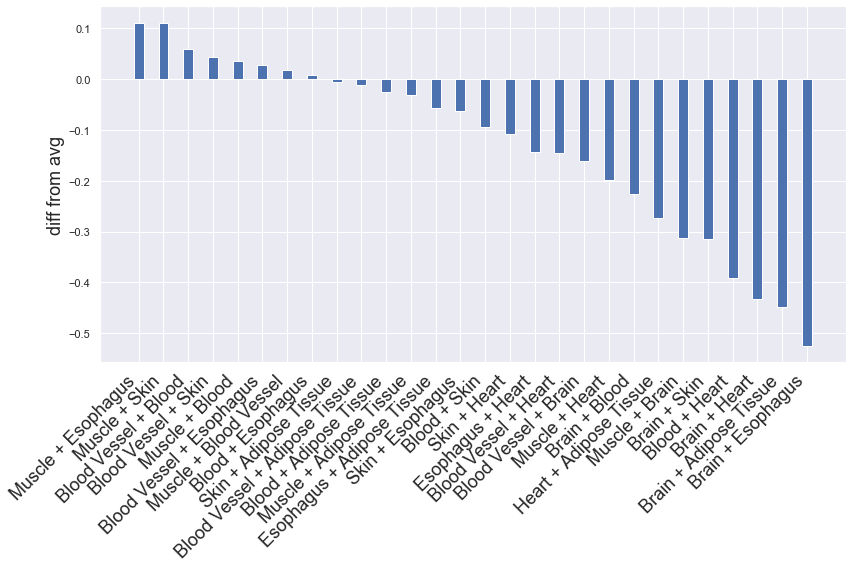

In [200]:
all_names = []
diff_max = []
diff_avg = []

for m in range(len(tissueData)):
    for n in range(m+1, len(tissueData)):
        i = tissues[m] # tissue names
        j = tissues[n]
        combined = [i, j, i + " + " + j]
        all_names.append(i + " + " + j)
        diff_max.append(pearson_corr[i + " + " + j][0] - max(pearson_corr[i][0], pearson_corr[j][0]))
        diff_avg.append(pearson_corr[i + " + " + j][0] - (pearson_corr[i][0] + pearson_corr[j][0])/2.0)

                    
fig, ax = plt.subplots(figsize=(12,8))
n=2
x_coords = np.arange(0,n*len(all_names), n)
ax.set_xticks(np.arange(0,n*len(all_names), n))
coeff = np.asarray(diff_max)
ax.set_xticklabels([all_names[i] for i in np.argsort(coeff)[::-1]], rotation=45, horizontalalignment='right', fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('diff from max', fontsize=ylabel_fontsize) 
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12,8))
n=2
x_coords = np.arange(0,n*len(all_names), n)
ax.set_xticks(np.arange(0,n*len(all_names), n))
coeff = np.asarray(diff_avg)
ax.set_xticklabels([all_names[i] for i in np.argsort(coeff)[::-1]], rotation=45, horizontalalignment='right', fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('diff from avg', fontsize=ylabel_fontsize) 
plt.tight_layout()

[66, 61, 62, 64, 66, 64, 58, 55, 43, 66, 62, 56, 62, 21, 66, 69, 33, 61, 66, 51, 38, 53, 64, 48, 62, 69, 37, 31, 21, 22, 66, 59, 47, 64, 55, 48, 67, 67, 37, 56, 63, 23, 66, 42, 68, 62, 61, 23, 36, 56, 64, 59, 51, 63, 49, 49, 64, 51, 61, 54, 33, 50, 60, 55, 53, 51, 67, 56, 60, 68, 42, 26, 38, 33, 67, 50, 34, 50, 62, 61, 60, 64, 62, 53, 62, 58, 55, 61, 56, 44, 28, 49, 67, 59, 69, 46, 64, 50, 70, 60, 49, 67, 63, 54, 64, 35, 68, 59, 68, 59, 53, 68, 62, 70, 66, 40, 50, 62, 59, 53, 66, 44, 62, 60, 59, 68, 40, 65, 59, 60, 29, 47, 66, 44, 47, 24, 58, 65, 57, 55, 65, 56, 61, 64, 64, 57, 22, 51, 61, 50, 46, 57, 34, 64, 55, 37, 68, 67, 55, 50, 69, 70, 63, 69, 53, 31, 48, 61, 64, 27, 53, 50, 46, 65, 63, 50, 55, 48, 31, 42, 35, 48, 35, 65, 57, 58, 65, 60, 69, 59, 36, 70, 56, 67, 67, 69, 59, 53, 56, 39, 28, 45, 45, 68, 38, 26, 49, 56, 42, 65, 64, 68, 70, 48, 59, 69, 66, 52, 41, 58, 70, 63, 30, 22, 44, 70, 70, 57, 48, 57, 66, 59, 50, 59, 57, 59, 48, 29, 21, 56, 63, 56, 62, 54, 70, 30, 63, 41, 32, 55,

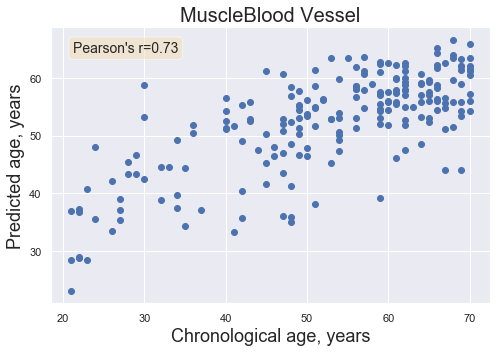

In [170]:
# hyperparameter tuning for dual models
i = "Muscle"
j = "Blood Vessel"
combineTissue = pd.concat([tissueData[i], tissueData[j]], axis=0, join='inner')
combineAge = pd.concat([ageData[i], ageData[j]], axis=0, join='inner')
combineAge = combineAge.iloc[0].values.tolist()
print(combineAge)
combineName = i+j

data[combineName] = combineTissue
age[combineName] = combineAge
print(combineName)
pearson_corr[combineName], true[combineName], prediction[combineName] = fit_xgboost_model(combineTissue, combineAge, combineName, search=True, n_iter=12)
pearson_corr[combineName] = graph_correlation(true[combineName], prediction[combineName], combineName)

[62, 64, 64, 58, 68, 55, 66, 62, 56, 63, 21, 66, 69, 61, 66, 51, 38, 53, 64, 48, 69, 31, 22, 66, 59, 55, 67, 37, 56, 63, 66, 42, 68, 62, 61, 56, 64, 25, 55, 54, 41, 49, 57, 49, 54, 33, 50, 60, 55, 53, 67, 56, 60, 68, 67, 42, 38, 33, 50, 64, 61, 62, 44, 67, 59, 46, 68, 62, 66, 50, 59, 66, 62, 44, 57, 47, 24, 65, 65, 50, 69, 61, 70, 63, 53, 31, 54, 64, 56, 53, 50, 46, 65, 63, 55, 48, 53, 70, 42, 48, 63, 67, 65, 57, 65, 69, 59, 68, 70, 65, 56, 67, 67, 69, 59, 47, 21, 64, 54, 61, 49, 48, 56, 37, 66, 55, 70, 63, 30, 44, 66, 59, 59, 57, 63, 59, 70, 56, 63, 56, 62, 54, 63, 41, 55, 61, 66, 59, 65, 60, 68, 66, 52, 57, 50, 64, 61, 50, 49, 59, 50, 69, 70, 58, 54, 63, 58, 40, 64, 60, 61, 54, 64, 57, 51, 69, 61, 65, 47, 68, 70, 58, 51, 54, 60, 63, 47, 66, 45, 62, 59, 40, 51, 59, 53, 63, 54, 68, 66, 68, 41, 44, 65, 70, 70, 69, 65, 64, 60, 54, 67, 58, 45, 62, 53, 55, 57, 47, 54, 65, 49, 68, 63, 57, 36, 68, 70, 67, 59, 57, 60, 62, 61, 49, 70, 57, 36, 53, 27, 70, 51, 66, 62, 63, 34, 69, 67, 70, 58, 68,

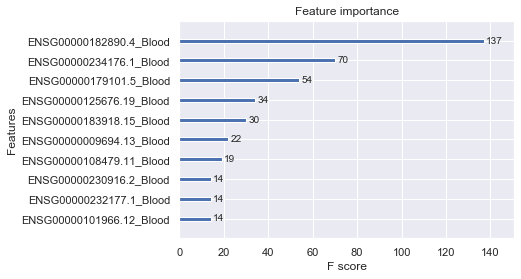

predictions made
[61.5111   52.66894  38.987175 51.463436 44.795193 58.1234   61.850037
 46.22055  56.417664 48.800438] [62 64 51 45 70 53 70 61 70 47]
(nan, nan)


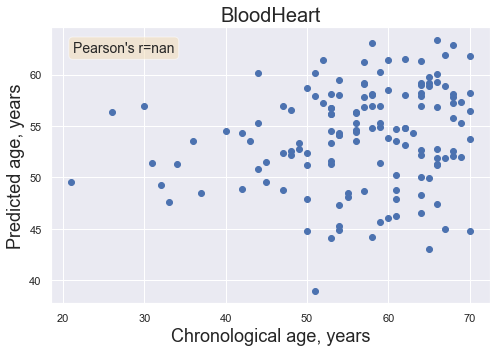

In [147]:
# for m in range(len(tissueData)):
#     for n in range(m+1, len(tissueData)):

# for m in range(2):
#     for n in range(m+1, 2):
#         i = tissues[m] # tissue names
#         j = tissues[n]

i = "Blood"
j = "Heart"
combineTissue = pd.concat([tissueData[i], tissueData[j]], axis=0, join='inner')
combineAge = pd.concat([ageData[i], ageData[j]], axis=0, join='inner')
combineAge = combineAge.iloc[0].values.tolist()
print(combineAge)
combineName = i+j

data[combineName] = combineTissue
age[combineName] = combineAge
print(combineName)
pearson_corr[combineName], true[combineName], prediction[combineName] = fit_xgboost_model(combineTissue, combineAge, combineName)

In [150]:
ss.pearsonr(true["BloodHeart"], prediction["BloodHeart"])
# print(pearson_corr["Muscle"])
# print(pearson_corr["Blood Vessel"])
# print(pearson_corr.keys())

(0.18986559086602048, 0.024649137561262625)

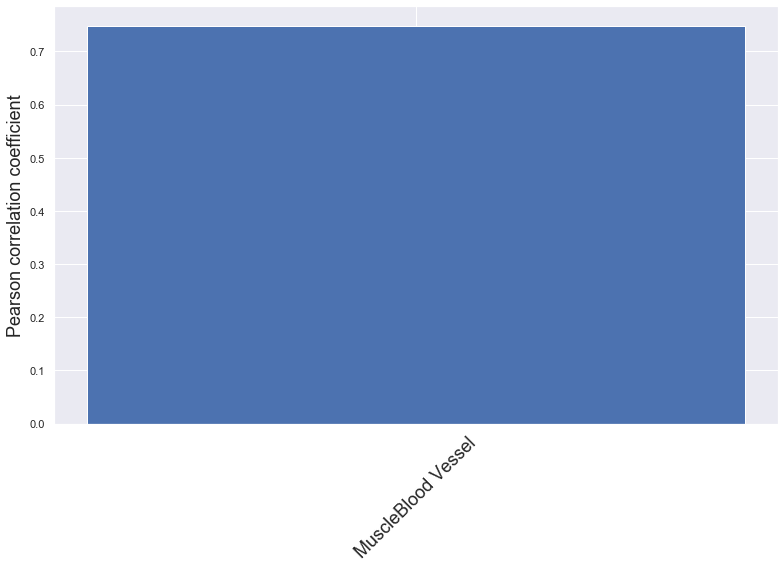

In [134]:
combineNames = []
for m in range(2):
    for n in range(m+1, 2):
        combineName = tissues[m] + tissues[n]
        combineNames.append(combineName)

fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(combineNames), n)
ax.set_xticks(np.arange(0,n*len(combineNames), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in combineNames])
ax.set_xticklabels([combineNames[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

data done
(1849, 22135) (793, 22135) (1849,) (793,)


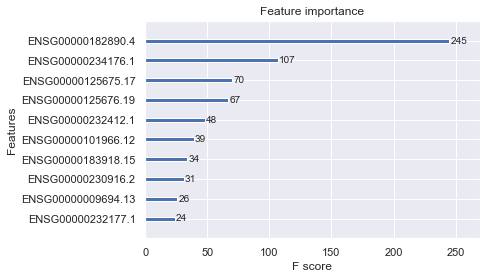

predictions made
[59.544895 58.09035  62.65191  55.091858 61.468708 51.301163 59.178616
 63.065598 57.463177 54.273968] [66 53 57 57 64 60 60 69 62 44]
prior pearson (nan, nan)
real pearson (0.7554523403213063, 2.1268243864770596e-147)


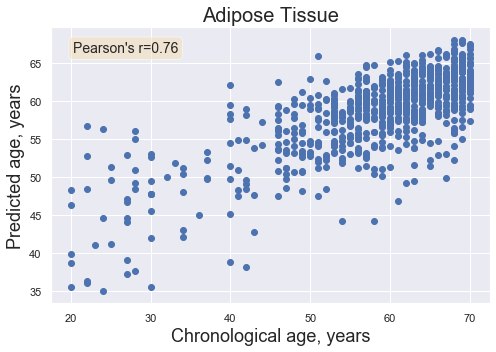

In [160]:
pearson_corr["Brain"], true["Brain"], prediction["Brain"] = fit_xgboost_model(data["Brain"], age["Brain"], "Brain")
graph_correlation(true["Brain"], prediction["Brain"])

# graph is labeled incorrectly

In [109]:
ageData = [pd.DataFrame([age[tissue]]) for tissue in tissues]

In [110]:
print(ageData[:2])

[   0    1    2    3    4    5    6    7    8    9    ...  793  794  795  796  \
0   66   57   61   63   62   64   66   53   64   58  ...   50   57   55   67   

   797  798  799  800  801  802  
0   30   66   67   24   53   50  

[1 rows x 803 columns],    0     1     2     3     4     5     6     7     8     9     ...  1325  \
0    66    66    61    62    62    64    64    64    66    66  ...    30   

   1326  1327  1328  1329  1330  1331  1332  1333  1334  
0    30    54    66    66    67    24    50    50    50  

[1 rows x 1335 columns]]


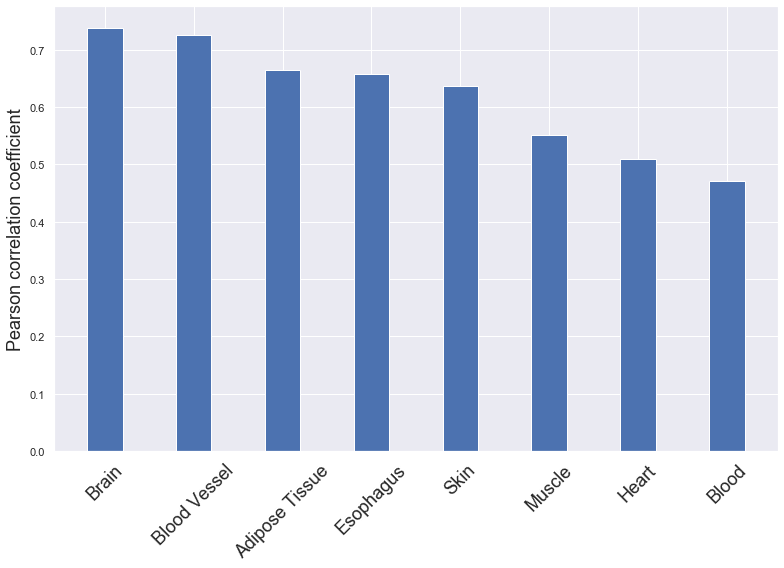

In [76]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr2[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

Muscle
(19544, 803)
data done
(562, 19544) (241, 19544) (562,)
predictions made
(0.6587135853150494, 2.2997094647166137e-31)
Blood Vessel
(21218, 1335)
data done
(934, 21218) (401, 21218) (934,)
predictions made
(0.8009061184403916, 6.753354708467427e-91)
Brain
(22135, 2642)
data done
(1849, 22135) (793, 22135) (1849,)
predictions made
(0.7554523403213063, 2.1268243864770596e-147)
Blood
(19334, 929)
data done
(650, 19334) (279, 19334) (650,)
predictions made
(0.560359528686625, 1.8161376642506876e-24)
Skin
(20767, 1809)
data done
(1266, 20767) (543, 20767) (1266,)
predictions made
(0.6148612873897659, 9.017397128880438e-58)
Esophagus
(21402, 1445)
data done
(1011, 21402) (434, 21402) (1011,)
predictions made
(0.623217483739894, 4.620782521085148e-48)
Heart
(20406, 861)
data done
(602, 20406) (259, 20406) (602,)
predictions made
(0.600079730991673, 1.0027529504437087e-26)
Adipose Tissue
(22099, 1204)
data done
(842, 22099) (362, 22099) (842,)
predictions made
(0.7186362601085831, 9.2734

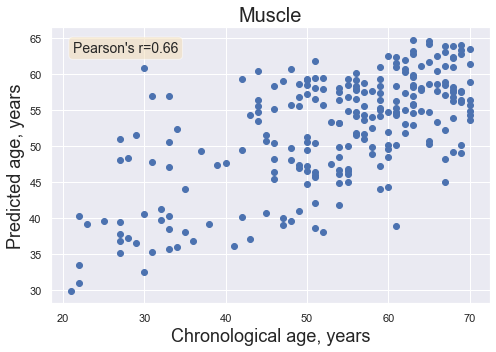

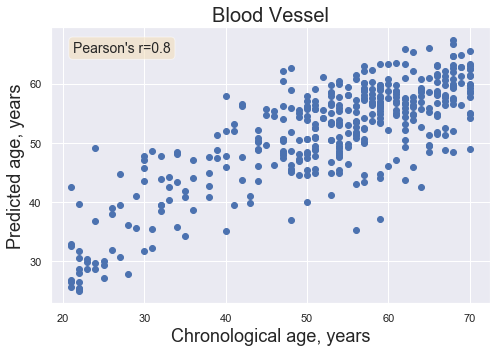

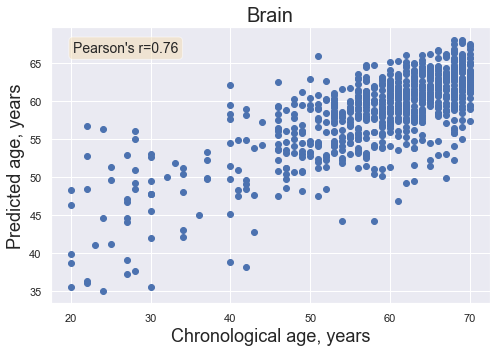

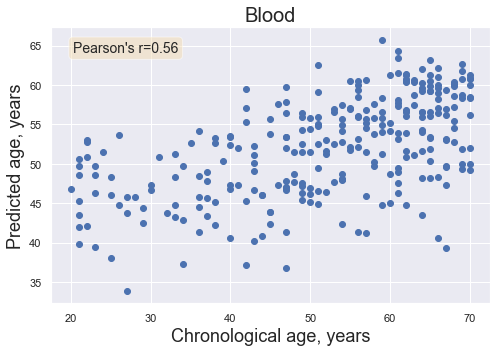

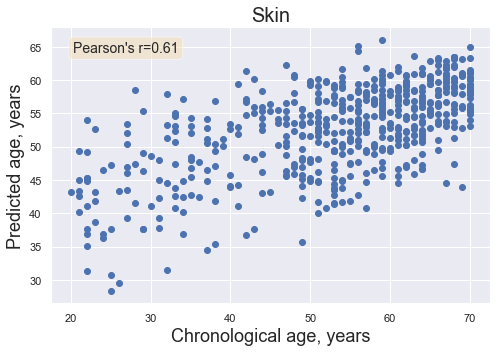

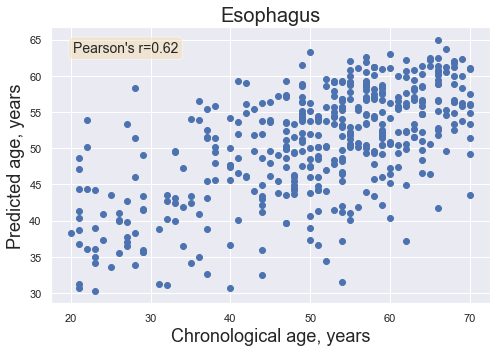

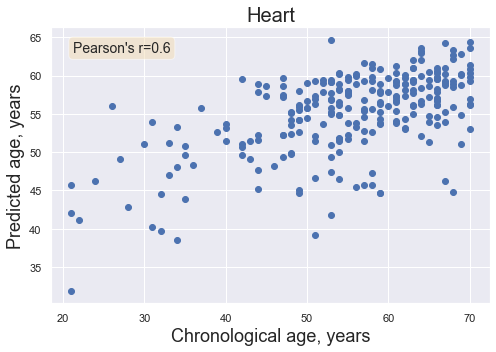

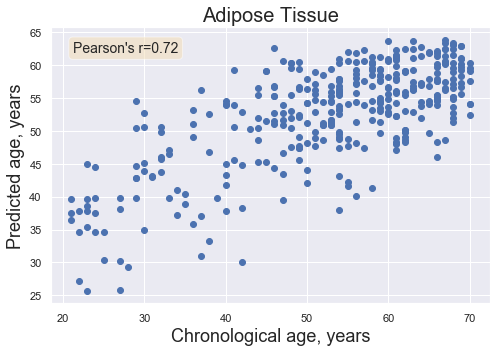

In [30]:
for i, tissue in enumerate(tissues): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(data[tissue], age[tissue])

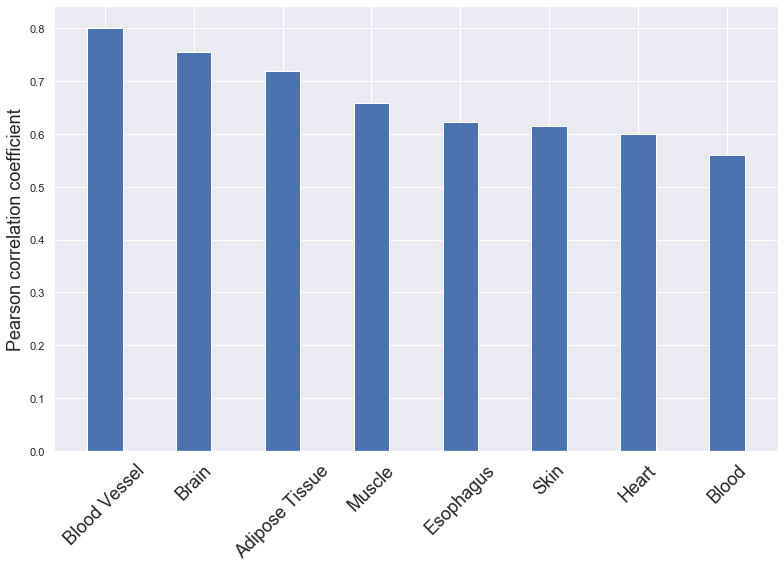

In [31]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

Muscle
(19544, 803)
data done
(562, 19544) (241, 19544) (562,) (241,)


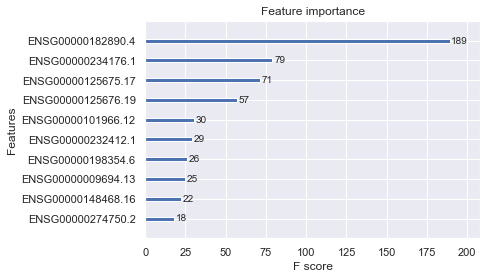

predictions made
[47.131157 35.66124  52.33046  56.954525 59.36375  48.110756 57.882343
 54.358635 62.858418 48.1544  ] [33 33 34 33 50 48 68 61 63 27]
prior pearson (nan, nan)
real pearson (0.6587135853150494, 2.2997094647166137e-31)
Blood Vessel
(21218, 1335)
data done
(934, 21218) (401, 21218) (934,) (401,)


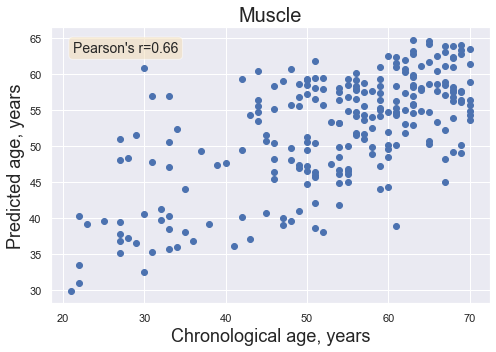

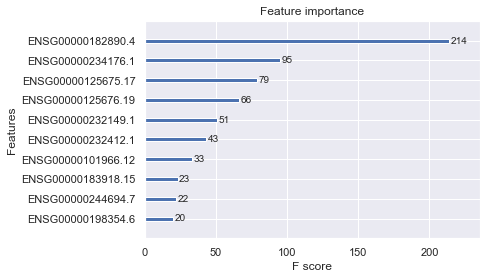

predictions made
[44.649296 58.957695 42.695538 40.054104 59.799206 58.148533 55.83008
 58.307796 54.511036 53.804718] [50 57 38 50 53 57 54 61 66 63]
prior pearson (nan, nan)
real pearson (0.8009061184403916, 6.753354708467427e-91)
Brain
(22135, 2642)
data done
(1849, 22135) (793, 22135) (1849,) (793,)


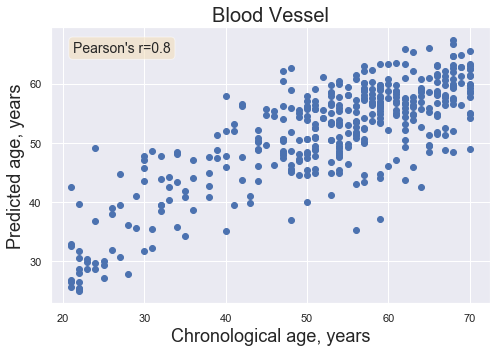

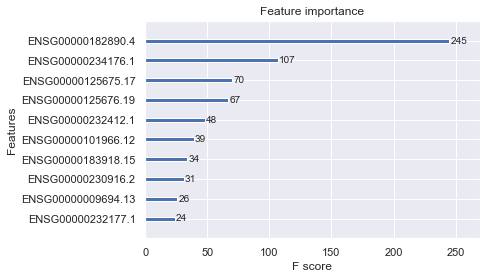

predictions made
[59.544895 58.09035  62.65191  55.091858 61.468708 51.301163 59.178616
 63.065598 57.463177 54.273968] [66 53 57 57 64 60 60 69 62 44]
prior pearson (nan, nan)
real pearson (0.7554523403213063, 2.1268243864770596e-147)
Blood
(19334, 929)
data done
(650, 19334) (279, 19334) (650,) (279,)


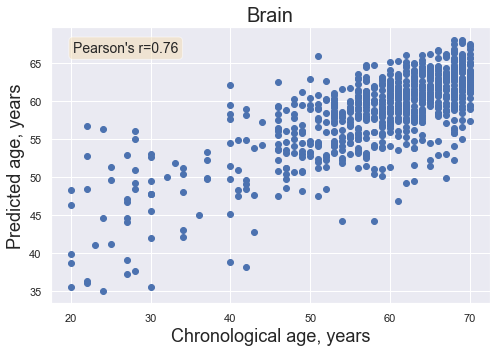

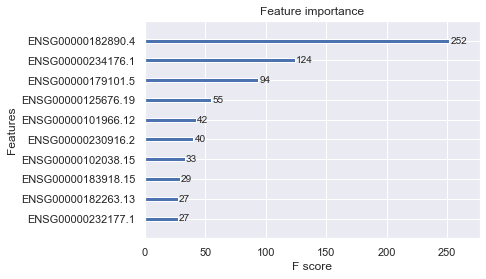

predictions made
[57.470905 61.37041  37.320686 54.535    43.86674  51.109344 55.637424
 56.979618 58.685482 42.045635] [63 62 34 57 45 43 57 55 69 21]
prior pearson (nan, nan)
real pearson (0.560359528686625, 1.8161376642506876e-24)
Skin
(20767, 1809)
data done
(1266, 20767) (543, 20767) (1266,) (543,)


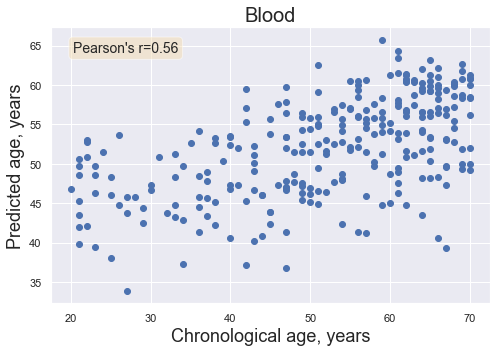

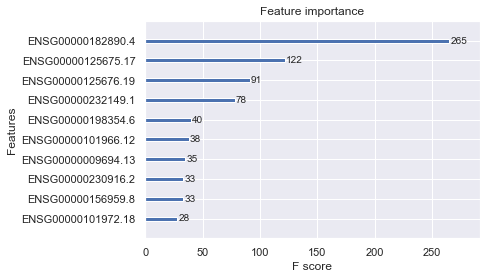

predictions made
[61.33966  48.65846  63.62453  46.322987 60.14907  40.141346 60.890873
 50.62379  57.679264 51.19504 ] [59 30 63 47 68 21 67 64 60 62]
prior pearson (nan, nan)
real pearson (0.6148612873897659, 9.017397128880438e-58)
Esophagus
(21402, 1445)
data done
(1011, 21402) (434, 21402) (1011,) (434,)


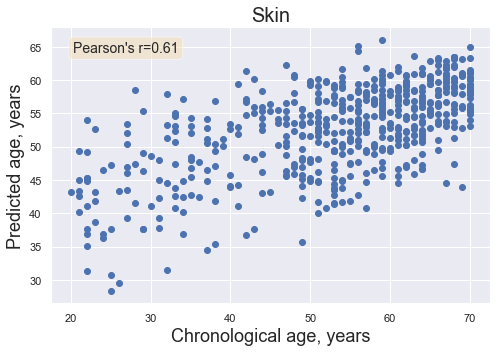

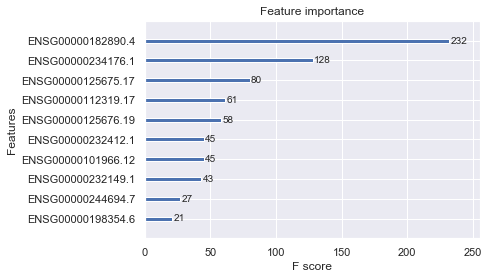

predictions made
[44.195965 41.459812 55.78705  45.453114 58.306793 57.92735  44.876472
 56.340656 49.004974 54.767952] [51 29 61 48 59 53 62 68 46 64]
prior pearson (nan, nan)
real pearson (0.623217483739894, 4.620782521085148e-48)
Heart
(20406, 861)
data done
(602, 20406) (259, 20406) (602,) (259,)


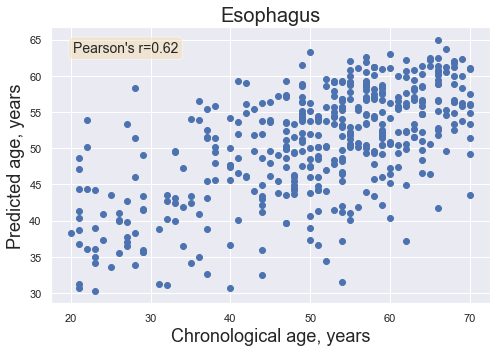

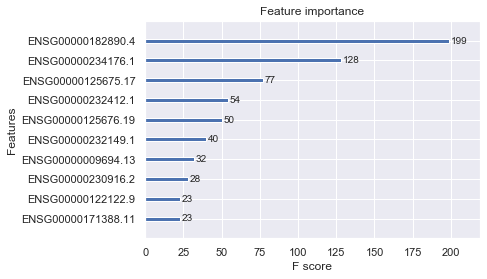

predictions made
[63.23957  51.692028 52.993195 60.8948   54.590816 57.24638  53.124077
 53.9103   55.68567  57.35733 ] [64 54 70 59 57 65 40 65 58 45]
prior pearson (nan, nan)
real pearson (0.600079730991673, 1.0027529504437087e-26)
Adipose Tissue
(22099, 1204)
data done
(842, 22099) (362, 22099) (842,) (362,)


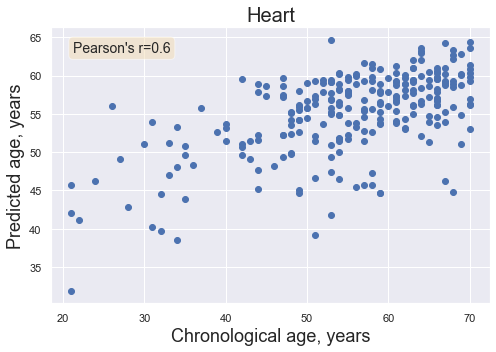

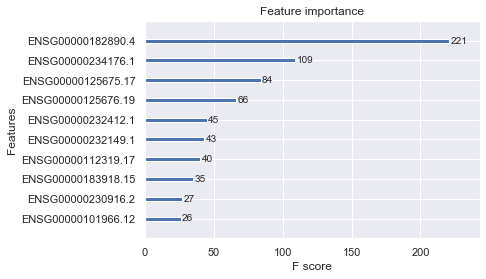

predictions made
[49.75725  62.27019  54.967567 38.603905 62.3877   42.180424 54.39501
 60.141895 34.6867   30.44332 ] [54 57 59 23 63 55 59 58 24 25]
prior pearson (nan, nan)
real pearson (0.7186362601085831, 9.273412748879631e-59)


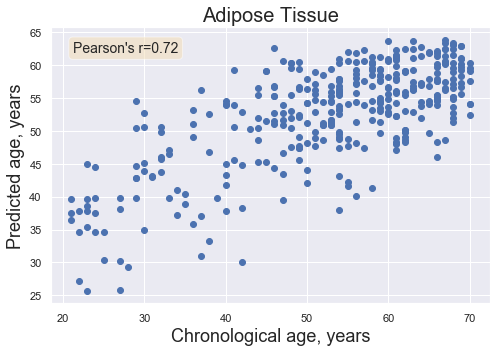

In [163]:
# second run, with important genes
for i, tissue in enumerate(tissues): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = fit_xgboost_model(data[tissue], age[tissue], tissue)
    pearson_corr[tissue] = graph_correlation(true[tissue], prediction[tissue], tissue)

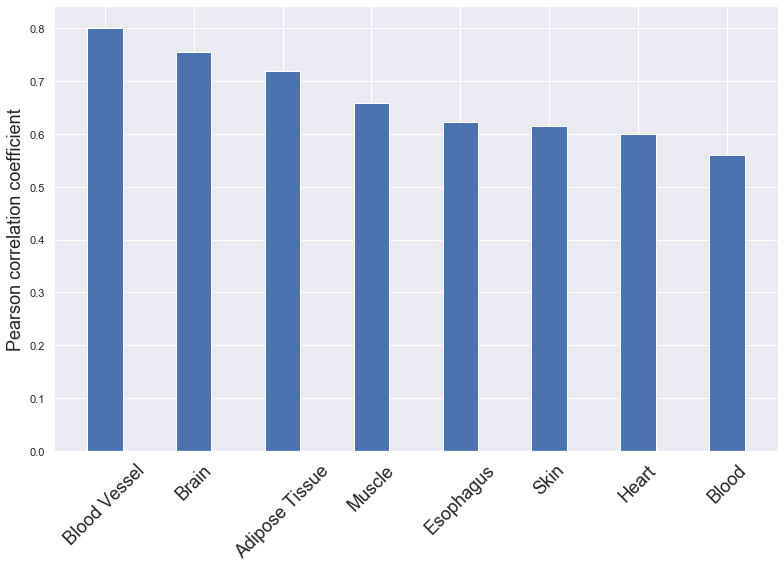

In [164]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

In [33]:
subtissues = ['Adipose_Subcutaneous', 'Adipose_Visceral_(Omentum)',
          'Whole_Blood', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_(Suprapubic)',
          'Skin_Sun_Exposed_(Lower_leg)', 'Heart_Atrial_Appendage',
          'Heart_Left_Ventricle', 'Esophagus_Gastroesophageal_Junction',
          'Esophagus_Mucosa', 'Esophagus_Muscularis'] # subtissues, skipped blood vessel and brain

In [34]:
for tissue in subtissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue, "subtissue")

663  samples,  56200 genes
22349 genes filtered out
0 samples filtered out
541  samples,  56200 genes
22140 genes filtered out
0 samples filtered out
755  samples,  56200 genes
17687 genes filtered out
0 samples filtered out
803  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
604  samples,  56200 genes
22904 genes filtered out
0 samples filtered out
701  samples,  56200 genes
23006 genes filtered out
0 samples filtered out
429  samples,  56200 genes
21462 genes filtered out
0 samples filtered out
432  samples,  56200 genes
19797 genes filtered out
0 samples filtered out
375  samples,  56200 genes
22134 genes filtered out
0 samples filtered out
555  samples,  56200 genes
21896 genes filtered out
0 samples filtered out
515  samples,  56200 genes
21983 genes filtered out
0 samples filtered out


In [66]:
for i, tissue in enumerate(subtissues[:2]):
    print(tissue)
    print(data[tissue].shape)
    cols = list(data[tissue].transpose().columns)
    setcols = set(cols)
    print(len(cols))
    print(len(setcols))
    uniques = [c for c in setcols if cols.count(c) > 1]
    print(uniques)
#     print(data[tissue].transpose().columns)
#     print(age[tissue])

Adipose_Subcutaneous
(22349, 663)
22349
21378
['RP11-504G3', 'RP11-524F11', 'CH507-9B2', 'CTD-2574D22', 'RP11-817O13', 'CH17-472G23', 'RP11-20I23', 'CTD-2035E11', 'RP11-196G11', 'RP11-455O6', 'RP4-657D16', 'RP11-53O19', 'AC000068', 'RP11-114H24', 'AC004540', 'RP11-108M9', 'RP13-270P17', 'RP11-428J1', 'RP11-158M2', 'CTD-3035K23', 'AC096574', 'RP11-1277A3', 'RP11-680G24', 'RP11-753H16', 'CTC-558O2', 'CTC-308K20', 'RP11-13K12', 'RP11-598F7', 'RP11-59H7', 'AC007193', 'CTD-3064M3', 'LINC01238', 'RP11-480I12', 'RP5-1112D6', 'RP11-30K9', 'RP11-493E12', 'RP11-23J9', 'AC137932', 'CTB-31O20', 'RP11-88E10', 'RP11-227G15', 'CTC-471J1', 'CTB-113P19', 'CTD-2036P10', 'CTC-338M12', 'CTC-529I10', 'AC002398', 'RP11-1379J22', 'RP1-59D14', 'RP11-1055B8', 'AC005154', 'RP5-1139B12', 'RP11-6O2', 'RP11-53B2', 'RP5-943J3', 'RP4-816N1', 'RP11-2E11', 'RP5-875H18', 'RP11-94C24', 'XXbac-B444P24', 'RP11-435O5', 'RP11-686D22', 'RP11-855A2', 'CTD-2666L21', 'RP11-214K3', 'AC079922', 'RP11-332H18', 'RP11-894P9', 'RP13-

['RP11-504G3', 'CH507-9B2', 'CTD-2574D22', 'RP11-817O13', 'CH17-472G23', 'RP11-20I23', 'CTD-2035E11', 'RP11-196G11', 'RP11-455O6', 'RP11-53O19', 'AC000068', 'RP11-114H24', 'AC004540', 'RP11-108M9', 'RP13-270P17', 'AC010524', 'RP11-428J1', 'RP11-158M2', 'CTD-3035K23', 'AC096574', 'RP11-1277A3', 'RP11-680G24', 'CTC-558O2', 'CTC-308K20', 'RP11-13K12', 'RP11-598F7', 'AC007193', 'CTD-3064M3', 'RP11-480I12', 'RP5-1112D6', 'RP11-30K9', 'RP11-23J9', 'AC137932', 'CTB-31O20', 'RP11-88E10', 'RP11-227G15', 'CTC-471J1', 'CTB-113P19', 'CTD-2036P10', 'CTC-338M12', 'CTC-529I10', 'AC002398', 'RP11-1379J22', 'RP1-59D14', 'RP11-1055B8', 'AC005154', 'RP5-1139B12', 'RP11-6O2', 'RP11-53B2', 'RP11-2E11', 'XXbac-B444P24', 'RP11-686D22', 'RP11-855A2', 'CTD-2666L21', 'RP11-214K3', 'AC079922', 'RP11-332H18', 'RP13-131K19', 'RP11-295D4', 'RP6-109B7', 'RP11-1334A24', 'RP11-1072A3', 'RP11-358B23', 'CTD-2527I21', 'RP11-378J18', 'AF127936', 'RP11-216N14', 'RP11-2C24', 'CTC-559E9', 'RP3-331H24', 'RP11-863K10', 'CTD-25

In [67]:
for i, tissue in enumerate(subtissues[:1]):
    transposed = data[tissue].transpose()
    print(transposed['RP11-504G3'])

                          RP11-504G3  RP11-504G3
GTEX-1117F-0226-SM-5GZZ7          12           9
GTEX-111CU-1826-SM-5GZYN           0           5
GTEX-111FC-0226-SM-5N9B8          11          19
GTEX-111VG-2326-SM-5N9BK          21          11
GTEX-111YS-2426-SM-5GZZQ           4           6
...                              ...         ...
GTEX-ZYVF-0226-SM-5GIEG           10           8
GTEX-ZYW4-0226-SM-5E44M            8           2
GTEX-ZYY3-0226-SM-5E45M            7           4
GTEX-ZZ64-1626-SM-5E43W            5           6
GTEX-ZZPU-2726-SM-5NQ8O           10           2

[663 rows x 2 columns]


In [52]:
for i, tissue in enumerate(subtissues): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(data[tissue], age[tissue])

Adipose_Subcutaneous
(22349, 663)
data done
(464, 22349) (199, 22349) (464,) (199,)
Index(['WASH7P', 'RP11-34P13', 'RP11-34P13', 'RP11-34P13', 'RP11-34P13',
       'AP006222', 'RP4-669L17', 'RP5-857K21', 'MTND1P23', 'MTND2P28',
       ...
       'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5',
       'MT-ND6', 'MT-TE', 'MT-CYB'],
      dtype='object', length=22349)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(subtissues), n)
ax.set_xticks(np.arange(0,n*len(subtissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in subtissues])
ax.set_xticklabels([subtissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

Muscle
(19544, 803)
data done
(562, 19544) (241, 19544) (562,)
done prior to search
done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     473.967647     10.445853         0.833926        0.020416   
1     622.312801     10.096117         0.922099        0.025941   
2     500.183423     17.639331         0.855999        0.064464   
3     360.104715      3.345290         0.962760        0.084082   
4     838.923478      9.596142         0.820042        0.032368   
5     511.066628     15.341116         0.924046        0.143510   
6     404.775849     29.738498         0.877391        0.198714   
7     358.057903      9.548917         0.907325        0.199782   
8     419.144395     23.219744         0.708222        0.143399   
9     255.758977     18.452285         0.477327        0.112378   

  param_subsample param_n_estimators param_min_child_weight param_max_depth  \
0               1                150                      2              10   
1 

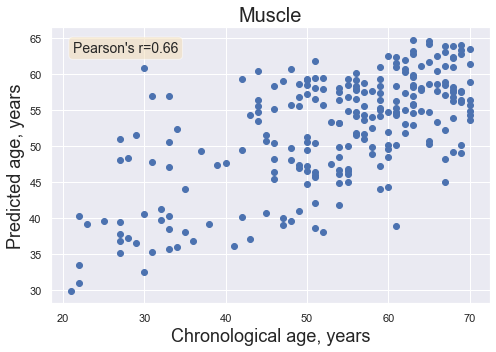

In [14]:
for i, tissue in enumerate(tissues[:1]): # only muscle
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(data[tissue], age[tissue], n_iter=10)
#     fit_xgboost_model(residual_no_outliers[tissue], ages[tissue], n_iter=3)    

In [ ]:
# from above: looks like hyperparams are good {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
-9.294894931041103

Blood Vessel
data done
(931, 21218) (400, 21218) (931,)
done prior to search
done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    1098.114059      6.349692         1.309571        0.096354   
1    1327.970546    114.944392         1.108240        0.259854   
2    1003.519009     43.056386         0.900258        0.094595   

  param_subsample param_n_estimators param_min_child_weight param_max_depth  \
0               1                150                      2              10   
1             0.9                200                      8              10   
2               1                100                      4              12   

  param_learning_rate param_colsample_bytree  ... mean_test_score  \
0                0.01                    0.8  ...      -15.292804   
1                0.01                      1  ...      -11.465545   
2                 0.3                      1  ...       -8.995537   

   std_test_score  rank_test_score  split0

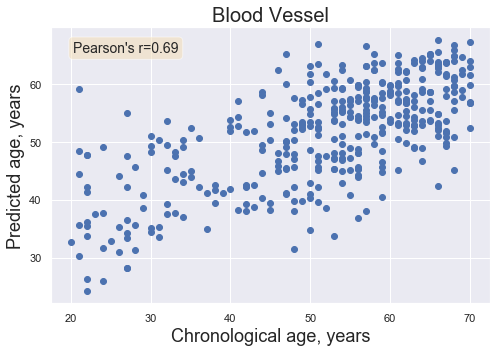

In [26]:
for i, tissue in enumerate(tissues[1:]): # only blood vessel
    print(tissue)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(residual_no_outliers[tissue], ages[tissue], n_iter=3)

# Additional analysis

### Comparing prediction accuracy for different tissues

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)


## Define most important covariates
These could be included in the model or regressed out to improve age prediction

In [ ]:
def gaussian_project(data, standardize=True, noise=1e-6):
    """ Project each row onto gaussian with matched mean, stdev 

    standardize : bool
        project each row onto N(0, 1), otherwise use N(mu_row, sigma_row),
        where mu_row is the mean of the row and sigma_row is the standard
        deviation
    noise : float
        add random noise drawn from interval (0, noise) to break ties
    """
    # add random noise to break ties
    err = np.random.random(data.shape) * noise
    data = data + err

    ppt = data.rank(axis=1) / (float(data.shape[1])+1.)
    if standardize:
        df = pd.DataFrame(ss.norm.ppf(ppt), index=ppt.index, 
                          columns=ppt.columns)
    else:
        mu = data.mean(axis=1)
        sigma = data.std(axis=1)
        df = {}
        for r in ppt.index:
            df[r] = pd.Series(ss.norm.ppf(ppt.loc[r], loc=mu.loc[r],
                                          scale=sigma.loc[r]), index=ppt.columns)
        df = pd.DataFrame(df).T
    return df
def find_covars_corr_with_first_2_pcs(tissue, data, ax):
        dt = data.copy()
        dt_g = gaussian_project(dt)

        pca = PCA().fit(dt_g)

        # extract principal components
        comps = pd.DataFrame(pca.components_.T, index=dt_g.columns,
                             columns=['PC%i' % (i+1) for i in range(len(pca.components_))])
        
        # choose potential important covariates (add whatever you are interesred in)
        covars = ['SMRIN', 'SMTSISCH', 'TRISCHD', 'ETHNCTY', 'RACE', 'AGE', 'BMI', 'SMNTRNRT', 'DTHRFG', 'DTHVNT', \
                  'SMATSSCR', 'SMALTALG', 'DTHHRDY', 'DTHHRDY']
        print('components', pca.explained_variance_ratio_[0:10])
    
        if np.fabs(sum(pca.explained_variance_ratio_)-1)>0.1:
            print('sum', sum(pca.explained_variance_ratio_))
        
        covs_r = {}
        covs_p = {}
        for pc in ['PC{}'.format(i+1) for i in range(10)]:
            _r = {}
            _p = {}
            for cv in covars:
                if cv in sampleMetaData.columns:
                    covar_vals = np.asarray(sampleMetaData.loc[comps.index, cv])
                elif cv in subjectMetaData.columns:
                    sample_subject_ids = [index.split("-")[0] + "-" + index.split("-")[1] \
                                 for index in list(comps.index)]
                    covar_vals = np.asarray(subjectMetaData.loc[sample_subject_ids, cv])
                _r[cv], _p[cv] = ss.pearsonr(covar_vals[np.isfinite(covar_vals)], \
                                             comps.loc[np.isfinite(covar_vals), pc])
                covs_r[pc] = pd.Series(_r)
                covs_p[pc] = pd.Series(_p)
        covs_r = pd.DataFrame(covs_r).loc[:, ['PC{}'.format(i+1) for i in range(10)]]
        covs_p = pd.DataFrame(covs_p).loc[:, ['PC{}'.format(i+1) for i in range(10)]]

        covarsMain = [covar for covar in covars if (covs_p.loc[covar,:][0:10]<0.05).any()==True]
        first_2_pcs_pars = [covar for covar in covars if (covs_p.loc[covar,:][0:2]<0.05).any()==True]
        ax.set_title(tissue)
        sns.heatmap(-1*np.log10(covs_p.loc[covarsMain,:]), ax=ax, vmax=10, annot=True, fmt=".1f")
        return(first_2_pcs_pars)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Muscle', data['Muscle'], ax)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Esophagus', data['Esophagus'], ax)

## Color PCA by parameter (age, RNA quality, ischemic time before) values to explore important parameters for each tissue

You can look at other technical or phenotypic covariates to find those that can possibly explain PCA patterns for tissues that clearly have clusters: skin and esophagus

In [ ]:
def plot_pca_colored_by(data, parameter):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    pca = decomposition.PCA(n_components=2)
    X = data.transpose().copy()
    pca.fit(X)
    y = np.asarray(parameter)
    X = pca.transform(X)
    y_no_na = y[np.where(np.isfinite(y))]
    y_min = np.min(y_no_na)
    y_max = np.max(y_no_na)
    
    for i in range(len(X[:, 0])):
        if np.isfinite(y[i]):
            alpha = float((y[i]-y_min)/float(y_max-y_min))
            ax.scatter(X[i, 0], X[i, 1], color = 'green', alpha = alpha, s=15)

In [ ]:
plot_pca_colored_by(residual_no_outliers["Esophagus"], SMTSISCH["Esophagus"])

## Sample size of each tissue
I chose top 8 tissues for the analysis above

In [ ]:
# tissues = list(set(sampleMetaData['SMTS']))
# sample_num = dict()
# for tissue in tissues:
#         data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)
#         sample_num[tissue] = data[tissue].shape[1]
# out_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(sample_num,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
sample_num = pd.read_pickle("/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl")
tissues = list(sample_num.keys())
sample_numbers = np.asarray([sample_num[tissue] for tissue in tissues])
indices = np.argsort(sample_numbers)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(range(len(tissues)), sample_numbers[indices])
ax.set_xticks(range(len(tissues)))
ax.set_xticklabels([tissues[index] for index in indices], rotation = 90)

## Plot sample age distribution for each tissue
Most samples are from elderly since they die more often

In [ ]:
for tissue in tissues:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(age[tissue])
    ax.set_title(tissue, fontsize=title_fontsize)